# Solar Flare Period Finding from Inglis et al

This reconstructs the analysis in [Inglis et al (2015)](http://adsabs.harvard.edu/abs/2015ApJ...798..108I) and 
[Inglis et al (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...833..284I/abstract). 

In this paper, the authors model the *periodogram* of the solar flare with three models: 
* a power law
* a power law and a Gaussian
* a broken power law

Here's the definitions of the models:

#### Power Law Model

$$
S_0(f) = A_0 f^{-\alpha_0} + C_0
$$

#### Power Law + Gaussian

$$
S_1(f) = A_1f^{-\alpha_1} + B \exp{\left(\frac{-(\ln{f} - \ln{f_p})^2}{2\sigma^2}\right)}
$$

Constraints on the model parameters:
* $ 1 < P < 300\,\mathrm{s}$
* $0.05 < \sigma < 0.25$

#### Broken Power Law

$S_2(f) = $

\begin{cases}
    A_2 f^{-\alpha1} + C_2,& \text{if } f < f_\mathrm{break}\\
    A_2 f^{-\alpha_b - \alpha_a} f^{-\alpha_a} + C_2,              & \text{if } f > f_\mathrm{break}
\end{cases}



## The GBM Data

* binned to 1-second resolution!
* for data from the 2015 paper, Inglis used 12-27 keV, 27-50 keV and 50-100 keV bins
* for data from the 2017 paper, Inglis used a single 5-25 keV bin
* flux normalized: $F* = \frac{F - \bar{F}}{\bar{F}}$
* flux also multiplied by Hann window function
* use BIC for model comparison: $\mathrm{BIC} = -2 \log{L} + k \log{n}$ for $k$ parameters and $n$ data points
* also use posterior predictive checking to test whether the preferred model works ok for the data


In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import numpy as np
import pandas as pd

import astropy.io.fits as fits

Let's first use the function to read in the catalogue file:

In [2]:
def read_catalogue(filename, datapath="./"):
    """ 
    Read in the Fermi/GBM solar flare catalogue and return 
    entries in a useful pandas DataFrame format.

    Parameters
    ----------
    filename : str
        Name of the Fermi/GBM catalogue file

    datapath : str
        path to the directory with the Fermi/GBM catalogue file

    Returns
    -------
    catdf : pandas.DataFrame
        A pandas.DataFrame with the catalogue data

    """

    # read in the catalogue
    catfile = open(datapath + filename, "r")
    catlines = catfile.readlines()
    catfile.close()


    catdict = {"date":[], "tstart":[], "hour":[], "minutes":[], "seconds":[],
               "duration":[], "peakcounts":[], "totalcounts":[],
               "det1": [], "det2":[], "det3":[], "det4":[], "trigname":[], "rhessi":[]}
    # run through all lines except for the first one
    # which contains the headers    
    for i,c in enumerate(catlines):
        #i += 1
        # split by spaces
        # need to do this because there are variable spaces
        # between columns and a variable number of columns
        csplit = c.split(" ")
        cfilter = list(filter(None, csplit))

        print(len(cfilter))
        # get the date of the observation
        catdict["date"].append(cfilter[0][:6])
        tstart = cfilter[2]
        catdict["tstart"].append(tstart)
        # get the hours and days
        catdict["hour"].append(int(tstart[:2]))
        catdict["minutes"].append(int(tstart[3:5]))
        catdict["seconds"].append(int(tstart[6:8]))
        catdict["duration"].append(int(cfilter[5]))
        catdict["peakcounts"].append(int(cfilter[6]))
        catdict["totalcounts"].append(int(cfilter[7]))

        catdict["det1"].append(cfilter[8])
        catdict["det2"].append(cfilter[9])
        catdict["det3"].append(cfilter[10])
        catdict["det4"].append(cfilter[11])

        if len(cfilter) == 13:
            if cfilter[12][:2] == "bn":
                catdict["trigname"].append(cfilter[12][:-2])
                catdict["rhessi"].append("")
            elif cfilter[12] == "\n":
                catdict["trigname"].append("")
                catdict["rhessi"].append("")
            else:
                catdict["rhessi"].append(cfilter[12][:-2])
                catdict["trigname"].append("")

        elif len(cfilter) == 14:
                catdict["trigname"].append(cfilter[12])
                catdict["rhessi"].append(cfilter[13][:-2])

        else:
                catdict["trigname"].append("")
                catdict["rhessi"].append("")

    catdf = pd.DataFrame(catdict)
    return catdf


This is the catalogue with only the few bursts that were explicitly shown in the Inglis papers.

In [3]:
cat = "../data/inglis_flares_2015.dat"

In [4]:
catdf = read_catalogue(cat)

14
14


In [5]:
catdf

date    tstart  hour  minutes  seconds  duration  peakcounts  \
0  110215  01:45:26     1       45       26      2184      877741   
1  110607  06:19:39     6       19       39      2161       69214   

   totalcounts det1  det2  det3  det4     trigname   rhessi  
0    403589952   n2  None  None  None  bn110215075  1102150  
1     44915560   n5    n4    n2    n1  bn110607266  1106070

In [6]:
i = 0

In [7]:
date = catdf.loc[i, "date"]
tstart = catdf.loc[i, "tstart"]
duration = catdf.loc[i, "duration"]
detecs = [catdf.loc[i, "det1"],catdf.loc[i, "det2"],catdf.loc[i, "det3"],catdf.loc[i, "det4"]]

In [8]:
tstart

'01:45:26'

In [17]:
datadir = "../data/"

In [18]:
import glob

In [19]:
d1 = detecs[0]

f = glob.glob(datadir+"glg_ctime_%s_%s_*.pha"%(d1, date))


In [20]:
f

['../data/glg_ctime_n2_110215_v00.pha']

In [21]:
d1

'n2'

In [22]:
detecs

['n2', 'None', 'None', 'None']

In [23]:
def convert_hours_seconds(time):
    """
    Convert a HH:MM:SS string into 
    seconds since midnight.

    Parameters
    ----------
    time : str
        A time in HH:MM:SS format

    Returns
    -------
    tnew : float 
        seconds since midnight

    """
    hours = float(time[:2])*3600.0
    minutes = float(time[3:5])*60.0
    seconds = float(time[6:])
    tnew = hours + minutes + seconds
    return tnew


In [24]:
hdulist = fits.open(f[0])

obs_start_met = hdulist[0].header["TSTART"]
obs_end_met = hdulist[0].header["TSTOP"]

# date plus start time of the observation, should be close to 
# midnight, but not quite midnight
date_obs = hdulist[0].header["DATE-OBS"]

if int(date[-2:]) > int(date_obs.split("T")[0].split("-")[-1]):
    neg = True
else: 
    neg = False

# just the observation start time in HH:MM:SS
obs_start = date_obs.split("T")[1]

# convert to seconds since midnight:
if neg:
    obs_start_sec = 86400 - convert_hours_seconds(obs_start)
else:
    obs_start_sec = convert_hours_seconds(obs_start)

hdulist.close()

# start time in seconds since midnight
tstart = convert_hours_seconds(tstart)

# tstart in MET is the time since observation start, i.e. the 
# seconds since midnight minus the seconds between midnight and the 
# start of the observation plus the MET of the start of the observation
tstart_met = tstart + obs_start_met + obs_start_sec


Now we can read out the Fermi/GBM files:

In [25]:
def read_fermi_gbm_file(filename, tstart, duration, emin=10, emax=30, add_seconds=10):
    """
    Read a CTIME file from Fermi/GBM.

    Parameters
    ----------
    filename : str
        A Fermi/GBM CTIME file name + path

    tstart : float
        The start time for the burst in Fermi Mission Elapsed Time (MET)

    duration : float 
        The duration of the flare in seconds

    emin, emax: float, float
        The minimum and maximum energies to use in keV

    add_seconds : float
        The number of seconds to add before and after the burst for a 
        baseline for the bakground.

    Returns
    -------
    tnew, cnew : np.array, np.array
        Time and counts arrays. Counts are summed over channels


    """
    hdulist = fits.open(filename)

    # get out channel-to-energy conversion
    channel = hdulist[1].data.field("CHANNEL")
    e_min_channel = hdulist[1].data.field("E_MIN")
    e_max_channel = hdulist[1].data.field("E_MAX")

    # only the channels between emin and emax are interesting
    valid_channels = channel[(e_min_channel >= emin) & (e_max_channel <= emax)]

    # get out the time and counts arrays
    time = hdulist[2].data.field("TIME")
    counts = hdulist[2].data.field("COUNTS")

    valid_counts = counts[:, valid_channels]
    valid_counts = np.sum(valid_counts, axis=1)

    # start and end times
    tend = tstart + duration
    ts = tstart - add_seconds
    te = tend + add_seconds

    min_ind = time.searchsorted(ts)
    max_ind = time.searchsorted(te)
    
    tnew = time[min_ind:max_ind]
    cnew = valid_counts[min_ind:max_ind]

    return tnew, cnew




In [26]:
detecs

['n2', 'None', 'None', 'None']

In [27]:
emin = 26.0
emax = 51.0
add_seconds = 10.0

In [29]:
# loop over all detectors and get out the light curve for each for 
# the given start time and duration
c_all = []
for d in detecs:
    if d == "None":
        continue
    else:
        f = glob.glob(datadir+"glg_ctime_%s_%s_*.pha"%(d, date))
        tnew, cnew = read_fermi_gbm_file(f[0], tstart_met, duration, emin=emin, emax=emax, add_seconds=add_seconds)
        c_all.append(cnew)


In [30]:
c_all = np.array(c_all)

# sum over all detectors
csum = np.sum(c_all, axis=0)

# compute length of each time bin
tdiff = np.diff(tnew)
# add the last time bin
tdiff = np.hstack([tdiff, tdiff[-1]])

# compute the count rate in counts/s
countrate = csum/tdiff


/Users/danielahuppenkothen/work/sw/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


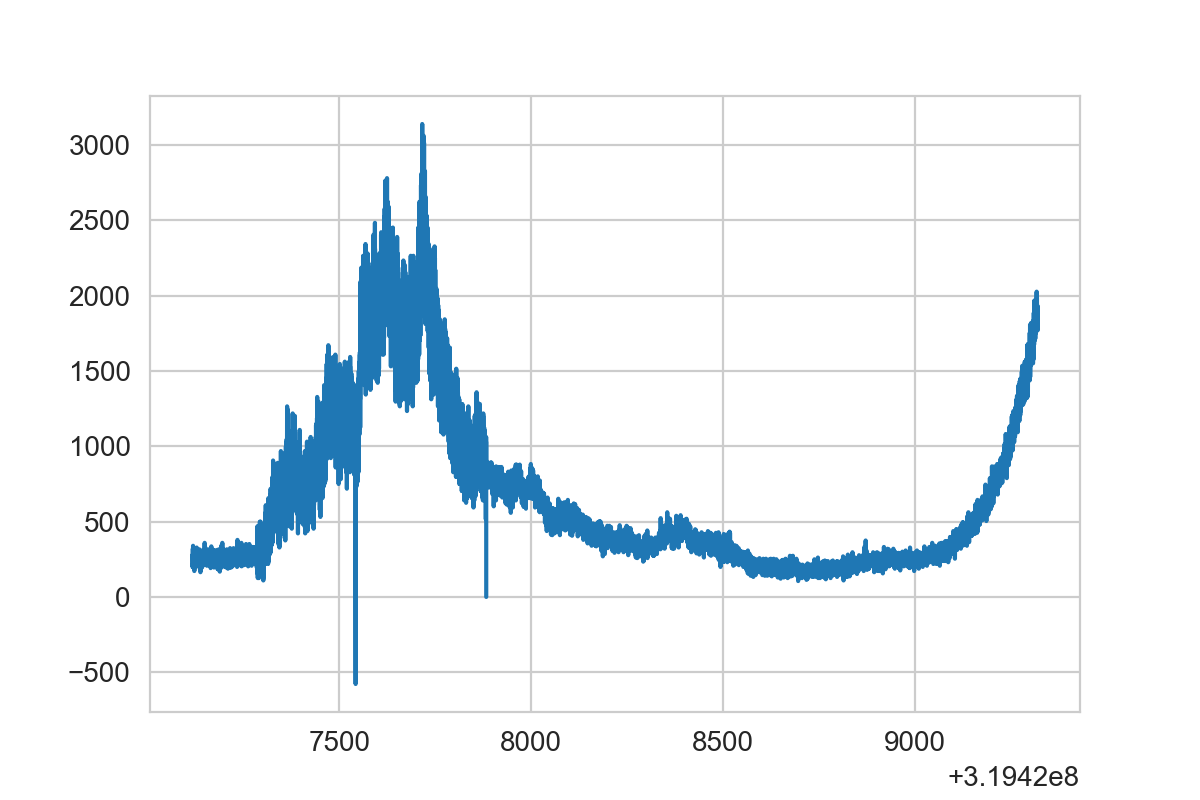

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(tnew, countrate)

The time resoution for Fermi/GBM data changes as a function of time, so let's take a look at what the time resolution looks like:

In [32]:
dt = np.diff(tnew)

<IPython.core.display.Javascript object>


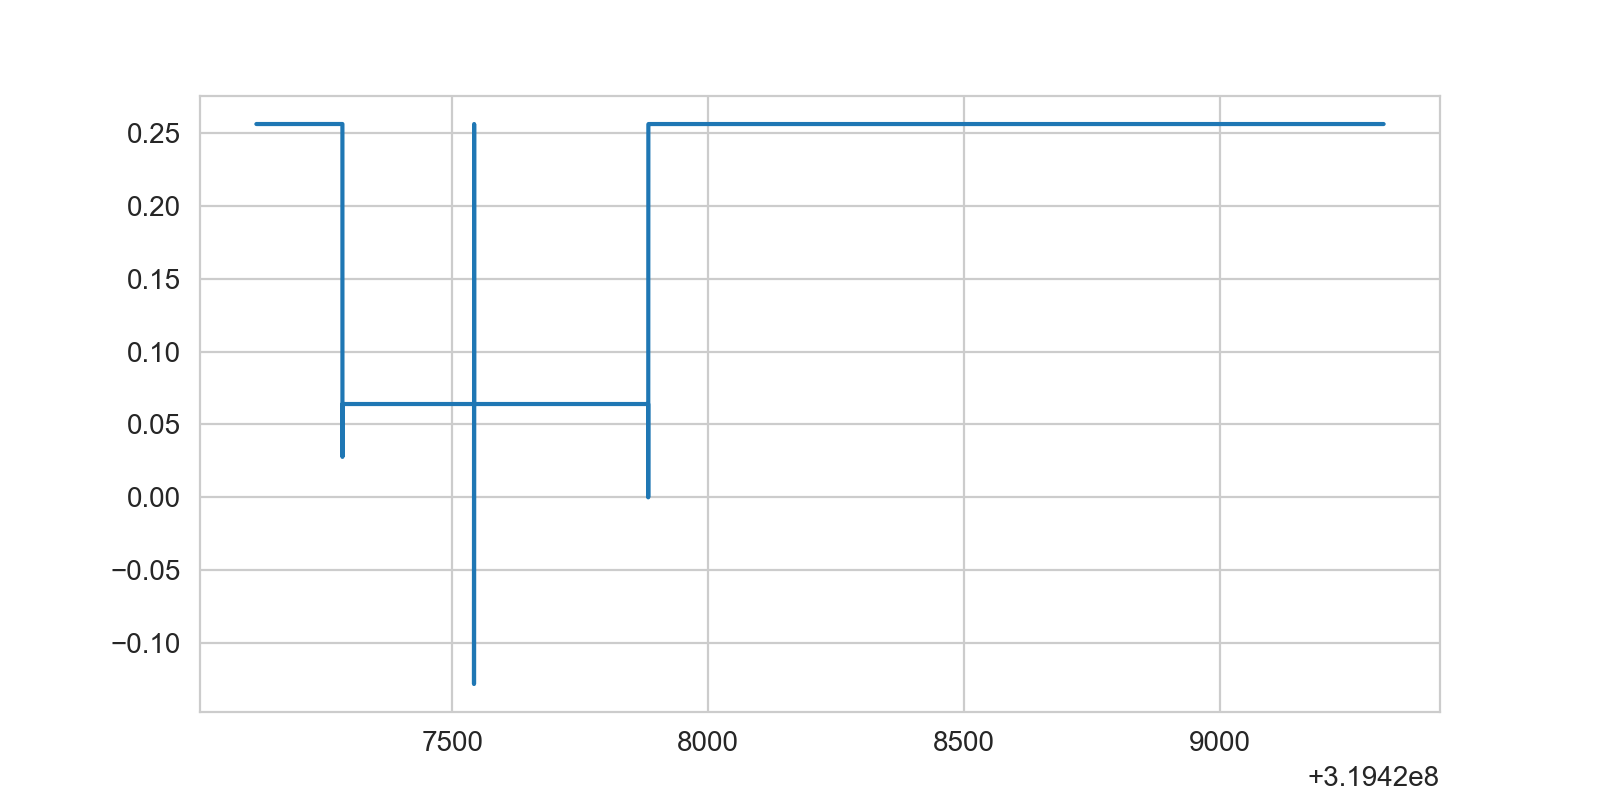

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(tnew[1:], dt)

Okay, that has two different time resolutions! Ugh. Okay, we're going to have to do some clever rebinning:

In [34]:
def rebin_data(x, y, dx_new, yerr=None, method='sum', dx=None):
    """Rebin some data to an arbitrary new data resolution. Either sum
    the data points in the new bins or average them.

    Parameters
    ----------
    x: iterable
        The dependent variable with some resolution ``dx_old = x[1]-x[0]``

    y: iterable
        The independent variable to be binned

    dx_new: float
        The new resolution of the dependent variable ``x``

    Other parameters
    ----------------
    yerr: iterable, optional
        The uncertainties of ``y``, to be propagated during binning.

    method: {``sum`` | ``average`` | ``mean``}, optional, default ``sum``
        The method to be used in binning. Either sum the samples ``y`` in
        each new bin of ``x``, or take the arithmetic mean.

    dx: float
        The old resolution (otherwise, calculated from median diff)

    Returns
    -------
    xbin: numpy.ndarray
        The midpoints of the new bins in ``x``

    ybin: numpy.ndarray
        The binned quantity ``y``

    ybin_err: numpy.ndarray
        The uncertainties of the binned values of ``y``.

    step_size: float
        The size of the binning step
    """

    y = np.asarray(y)
    yerr = np.zeros_like(y)

    #dx_old = assign_value_if_none(dx, np.median(np.diff(x)))
    dx_old = np.diff(x)

    if np.any(dx_new < dx_old):
        raise ValueError("New frequency resolution must be larger than "
                         "old frequency resolution.")


    # left and right bin edges
    # assumes that the points given in `x` correspond to 
    # the left bin edges
    xedges = np.hstack([x, x[-1]+np.diff(x)[-1]])

    # new regularly binned resolution
    xbin = np.arange(xedges[0], xedges[-1]+dx_old[-1], dx_new)

    output, outputerr, step_size = [], [], []

    for i in range(len(xbin)-1):
        total = 0
        total_err = 0

        nn = 0

        xmin = xbin[i]
        xmax = xbin[i+1]
        min_ind = xedges.searchsorted(xmin)
        max_ind = xedges.searchsorted(xmax)

        total += np.sum(y[min_ind:max_ind-1])
        total_err += np.sum(yerr[min_ind:max_ind-1])
        nn += len(y[min_ind:max_ind-1])

        prev_dx = xedges[min_ind] - xedges[min_ind-1]
        prev_frac = (xedges[min_ind] - xmin)/prev_dx
        total += y[min_ind-1]*prev_frac
        total_err += yerr[min_ind-1]*prev_frac
        nn += prev_frac

        if xmax <= xedges[-1]:
            dx_post = xedges[max_ind] - xedges[max_ind-1]
            post_frac = (xmax-xedges[max_ind-1])/dx_post
            total += y[max_ind-1]*post_frac
            total_err += yerr[max_ind-1]*post_frac
            nn += prev_frac

        output.append(total)
        outputerr.append(total_err)
        step_size.append(nn)

    output = np.asarray(output)
    outputerr = np.asarray(outputerr)

    if method in ['mean', 'avg', 'average', 'arithmetic mean']:
        ybin = output / np.float(step_size)
        ybinerr = outputerr / np.sqrt(np.float(step_size))

    elif method == "sum":
        ybin = output
        ybinerr = outputerr

    else:
        raise ValueError("Method for summing or averaging not recognized. "
                         "Please enter either 'sum' or 'mean'.")

    tseg = x[-1] - x[0] + dx_old

    #if (tseg / dx_new % 1) > 0:
    #    ybin = ybin[:-1]
    #    ybinerr = ybinerr[:-1]

    #new_x0 = (x[0] - (0.5 * dx_old)) + (0.5 * dx_new)
    #xbin = np.arange(ybin.shape[0]) * dx_new + new_x0

    return xbin[:-1], ybin, ybinerr, step_size

In [35]:
tbin, cbin, cbinerr, step_size = rebin_data(tnew, csum, 1.0, yerr=None, method='sum')

<IPython.core.display.Javascript object>


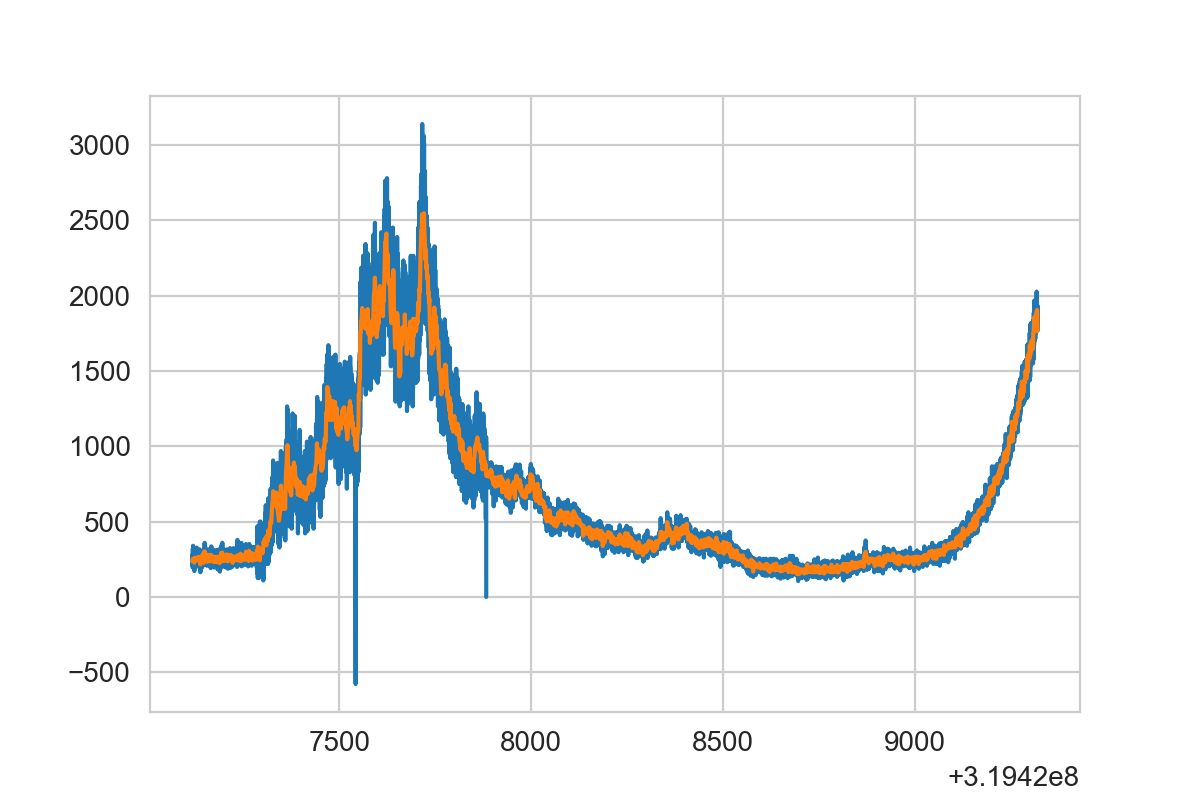

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(tnew, countrate)
ax.plot(tbin, cbin)

Ok, that looks good! 

## Modelling the Data

In [60]:
from stingray import Lightcurve, Powerspectrum
from stingray.modeling import PSDLogLikelihood, PSDParEst

First step, according to Inglis et al, is to normalize the input data according to 

$$
I_\mathrm{norm} = \frac{I - \vec{I}}{\vec{I}}
$$

In [61]:
mean_cbin = np.mean(cbin)
cbin_norm = (cbin - mean_cbin)/mean_cbin

In [62]:
lc = Lightcurve(tbin, cbin_norm)

In [63]:
len(lc)

2204

In [64]:
lc = lc.truncate(stop=2000)

Now we need to generate a Hann window function:

In [65]:
import scipy.signal
window = scipy.signal.hann(lc.n)

multiply the light curve by the window:

In [66]:
lc.counts *= window

<IPython.core.display.Javascript object>


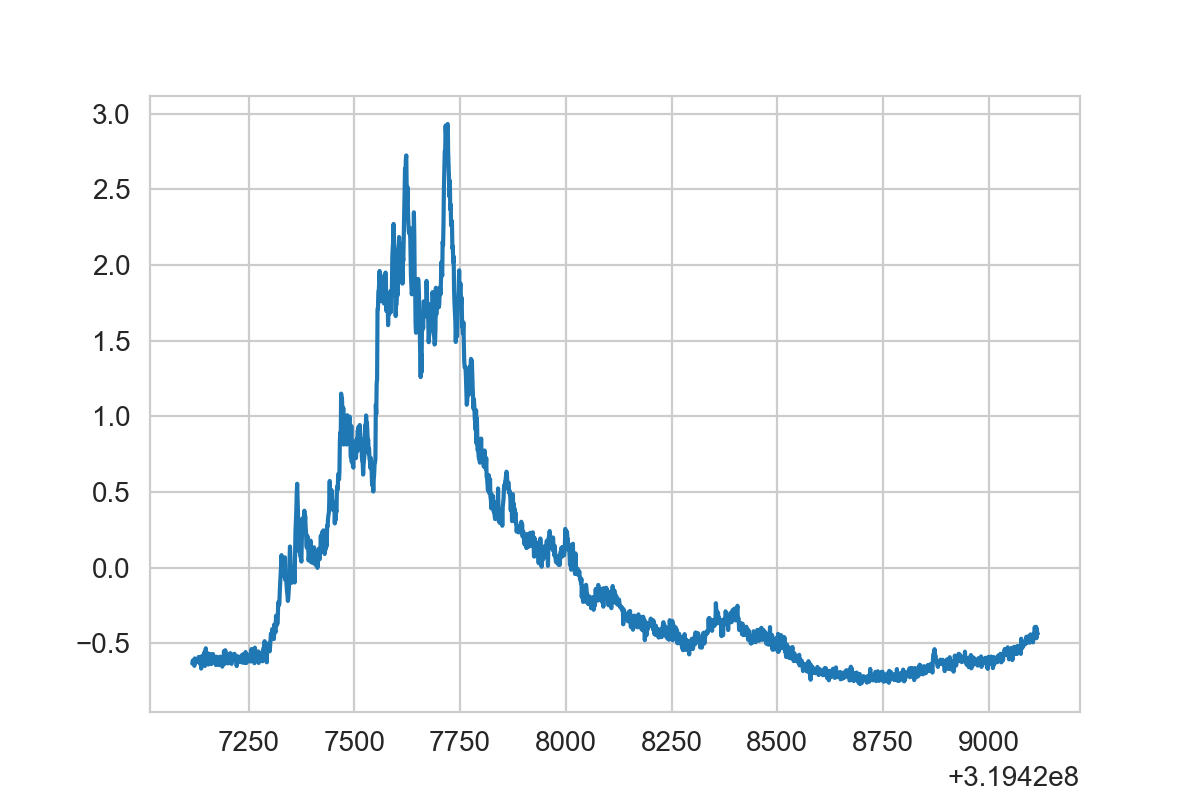

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(lc.time, lc.countrate)

What does the PSD of this light curve look like?

In [68]:
ps = Powerspectrum(lc, norm="abs")

<IPython.core.display.Javascript object>


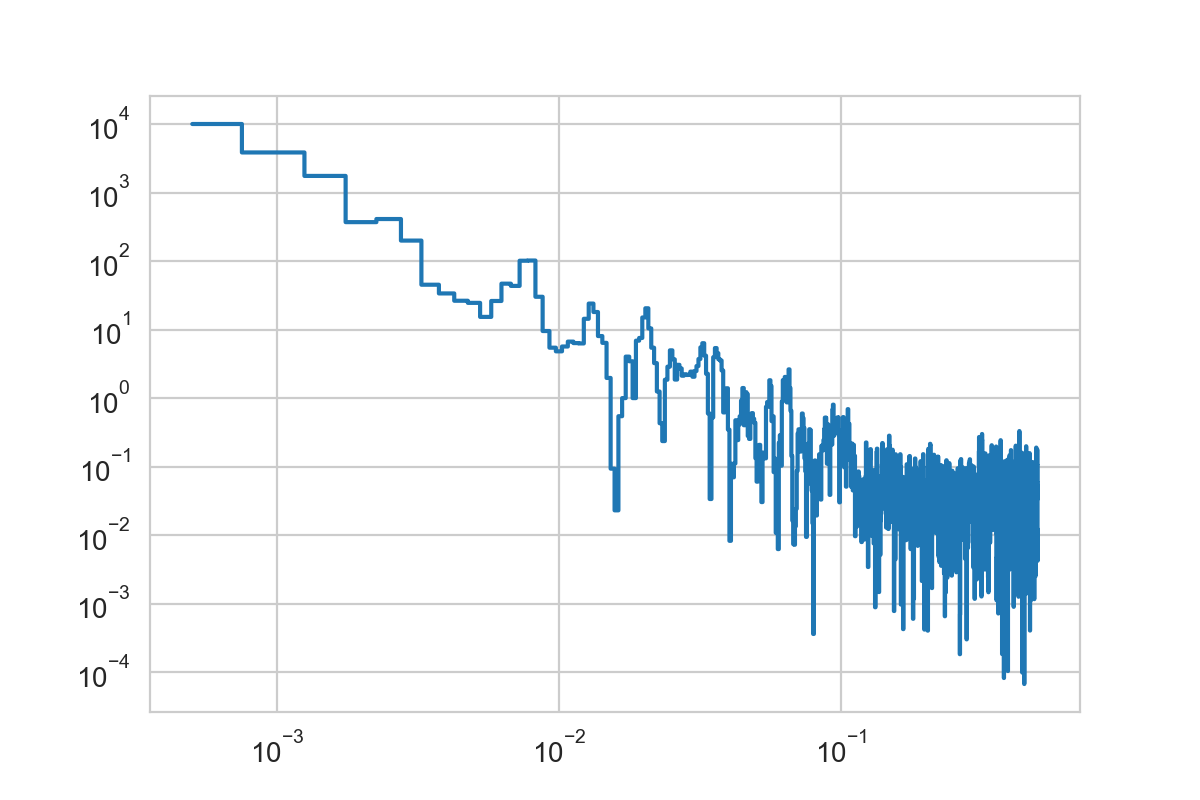

In [69]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.loglog(ps.freq, ps.power, linestyle="steps-mid")

Let's now make the functions we're going to use for modelling:

In [70]:
from astropy.modeling import models

In [114]:
# define power law component
pl = models.PowerLaw1D()

# fix x_0 of power law component
pl.x_0.fixed = True

# define constant
c = models.Const1D()

# make compound model
s0 = pl + c

In [115]:
s0.param_names

('amplitude_0', 'x_0_0', 'alpha_0', 'amplitude_1')

In [116]:
s0p = 

In [123]:
s0_prior = {"amplitude_0": (lambda amp: (-10 < np.log(amp)) & (np.log(amp) < 10)),
            "alpha_0": (lambda alpha: (-1 < alpha) & (alpha < 6)),
            "amplitude_1": (lambda amp1: (-20 < np.log(amp1)) & (np.log(amp1) < 10))}

Now let's make a compound model that includes the Gaussian function. The Gaussian uses $\ln(f)$ for the frequency, so we'll need to build our own model

In [124]:
from astropy.modeling.models import custom_model

In [130]:
@custom_model
def LogGaussian(x, amplitude=1.0, period=1.0, stddev=1.0):
    logx = np.log(x)
    
    amp_total = amplitude/np.sqrt(2. * np.pi * stddev**2.)
    gauss = amp_total * np.exp(-(np.log(x) - np.log(1./period))**2./(2.*stddev**2.))
    
    return gauss

In [131]:

g = LogGaussian()

s1 = pl + g + c

In [132]:
s1.param_names

('amplitude_0',
 'x_0_0',
 'alpha_0',
 'amplitude_1',
 'period_1',
 'stddev_1',
 'amplitude_2')

In [133]:
s1_prior = {"amplitude_0": (lambda amp: (-10 < np.log(amp)) & (np.log(amp) < 10)),
            "alpha_0": (lambda alpha: (-1 < alpha) & (alpha < 6)),
            "amplitude_1": (lambda amp1: (-6 < np.log(amp1)) & (np.log(amp1) < 5)),
            "period_1": (lambda period: (1 < period) & (period < 300)),
            "stddev_1": (lambda stddev: (0.05 < stddev) & (stddev < 0.25)),
            "amplitude_2": (lambda amp2: (-20 < np.log(amp2)) & (np.log(amp2) < 10)),
}

Finally, we need the broken power law plus a constant:

In [134]:
# broken power law model
bpl = models.BrokenPowerLaw1D()

# add constant
s2 = bpl + c

In [135]:
s2.param_names

('amplitude_0', 'x_break_0', 'alpha_1_0', 'alpha_2_0', 'amplitude_1')

In [136]:
np.log(1e-4)

-9.210340371976182

In [137]:
np.log(1e2)

4.605170185988092

In [169]:
s2_prior = {"amplitude_0": (lambda amp: (-10 < np.log(amp)) & (np.log(amp) < 10)),
            "alpha_1_0": (lambda alpha: (-1 < alpha) & (alpha < 6)),
            "alpha_2_0": (lambda alpha: (-1 < alpha) & (alpha < 6)),
            "x_break_0": (lambda fbreak: (-10 < np.log(fbreak)) & (np.log(fbreak) < 6)),
            "amplitude_1": (lambda amp1: (-20 < np.log(amp1)) & (np.log(amp1) < 10))}

Ok, cool. Now we can define the different likelihoods:

In [170]:
from stingray.modeling import PSDPosterior

In [171]:
ll_s0 = PSDPosterior(ps.freq, ps.power, s0, m=1, priors=s0_prior)

ll_s1 = PSDPosterior(ps.freq, ps.power, s1, m=1, priors=s1_prior)

ll_s2 = PSDPosterior(ps.freq, ps.power, s2, m=1, priors=s2_prior)

Let's stick these into the optimizer:

In [217]:
parest = PSDParEst(ps, fitmethod="powell", max_post=True)

We need some starting values for our different models:

In [218]:
s0.param_names

('amplitude_0', 'x_0_0', 'alpha_0', 'amplitude_1')

In [219]:
s0_test = [10, 2.0, 1e-4]

In [220]:
s1.param_names

('amplitude_0',
 'x_0_0',
 'alpha_0',
 'amplitude_1',
 'period_1',
 'stddev_1',
 'amplitude_2')

In [227]:
s1_test = [1, 2.0, 1, 20, 0.1, 1e-4]

In [228]:
ll_s1(s1_test)

-3380.937409584516

In [229]:
s2_test = [1, 0.02, 0.5, 1.5, 1e-4]

In [230]:
ll_s2(s2_test)

-3287.1851716788233

In [231]:
res0 = parest.fit(ll_s0, s0_test)

In [232]:
res1 = parest.fit(ll_s1, s1_test)

In [233]:
res2 = parest.fit(ll_s2, s2_test)

<IPython.core.display.Javascript object>


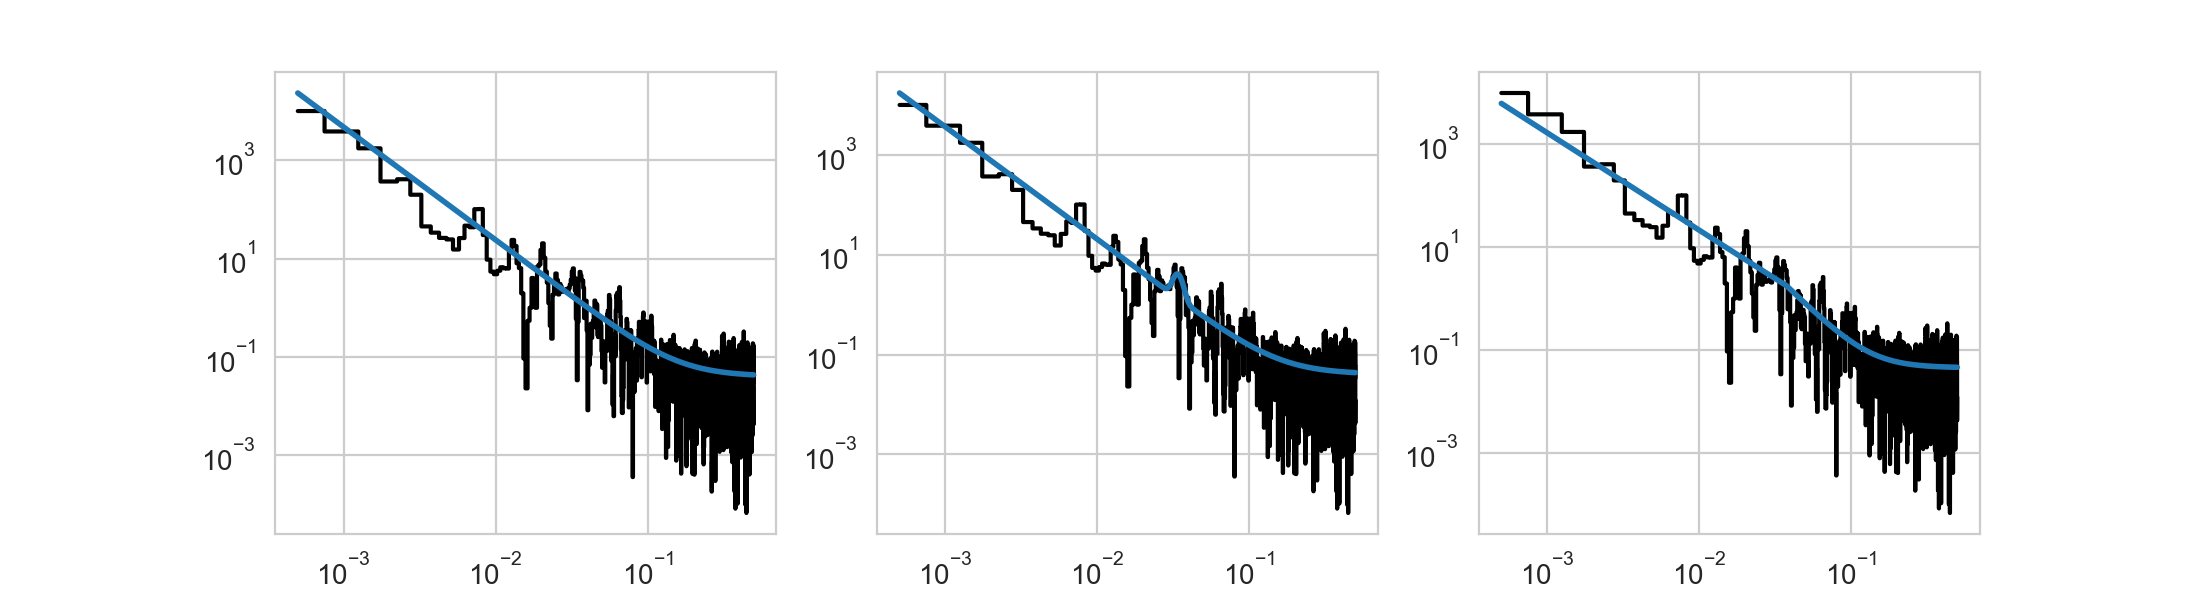

In [234]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11,3))

ax1.loglog(ps.freq, ps.power, linestyle="steps-mid", color="black")
ax1.plot(ps.freq, res0.mfit, lw=2)

ax2.loglog(ps.freq, ps.power, linestyle="steps-mid", color="black")
ax2.plot(ps.freq, res1.mfit, lw=2)

ax3.loglog(ps.freq, ps.power, linestyle="steps-mid", color="black")
ax3.plot(ps.freq, res2.mfit, lw=2)



The code automatically calculates the BIC. Let's see what the BIC looks like:

In [235]:
res0.bic

-1221.9555391852987

In [236]:
res1.bic

-1208.0420916116734

In [237]:
res2.bic

-1217.9602459596642

In [238]:
dbic1 = res1.bic - res0.bic

In [239]:
dbic2 = res1.bic - res2.bic

In [240]:
dbic3 = res2.bic - res0.bic

In [241]:
print("Delta BIC for QPO+PL versus PL model (large positive number means PL is favoured): " + str(dbic1))
print("Delta BIC for QPO+PL versus BPL model (large positive number means BPL is favoured): " + str(dbic2))
print("Delta BIC for BPL versus PL model (large positive number means PL is favoured): " + str(dbic3))

Delta BIC for QPO+PL versus PL model (large positive number means PL is favoured): 13.913447573625263
Delta BIC for QPO+PL versus BPL model (large positive number means BPL is favoured): 9.918154347990821
Delta BIC for BPL versus PL model (large positive number means PL is favoured): 3.995293225634441


Let's write a function that can do this in one go:

In [242]:
datadir

'../data/'

In [243]:
lc_files = glob.glob(datadir + "../data/*_lc.dat")

-0.9822600989737403
1.7795373711093152


<IPython.core.display.Javascript object>


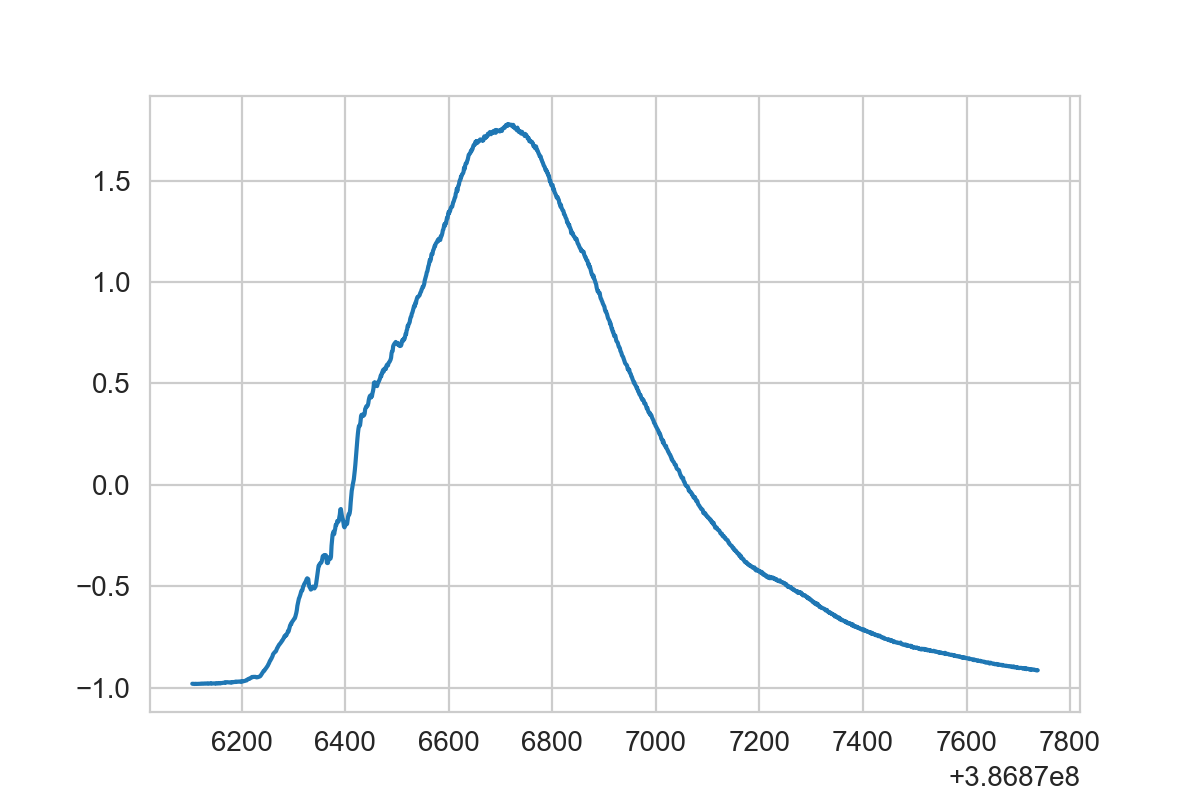

-0.7226522536655426
6.0381084444296045


<IPython.core.display.Javascript object>


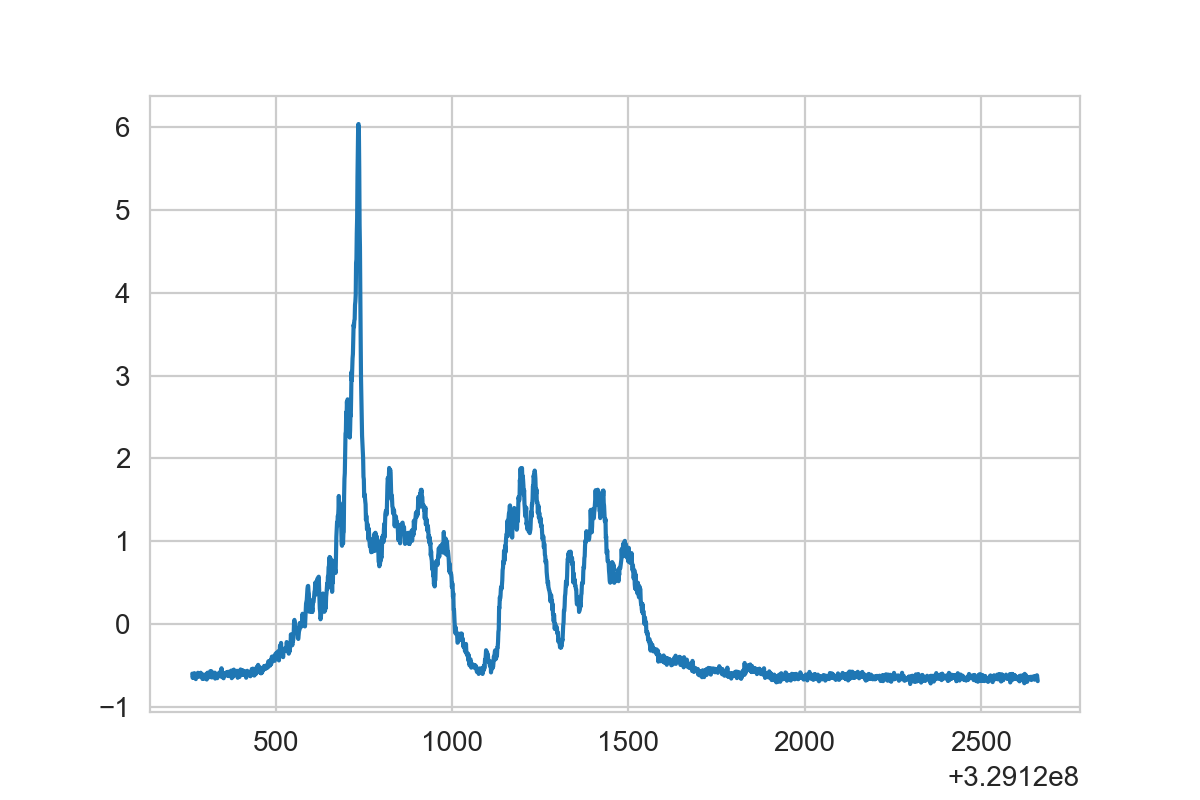

-0.8728594020131976
3.4464796165907234


<IPython.core.display.Javascript object>


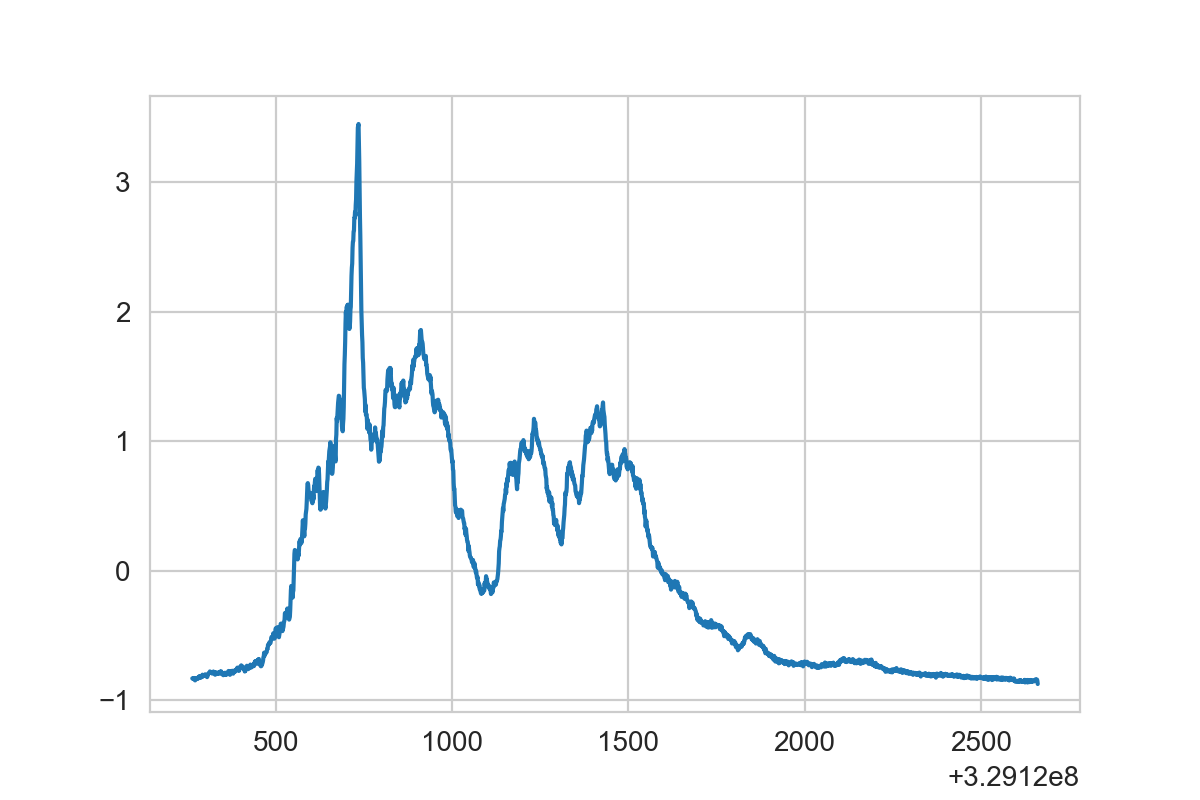

-0.9230468804432845
2.247226579621969


<IPython.core.display.Javascript object>


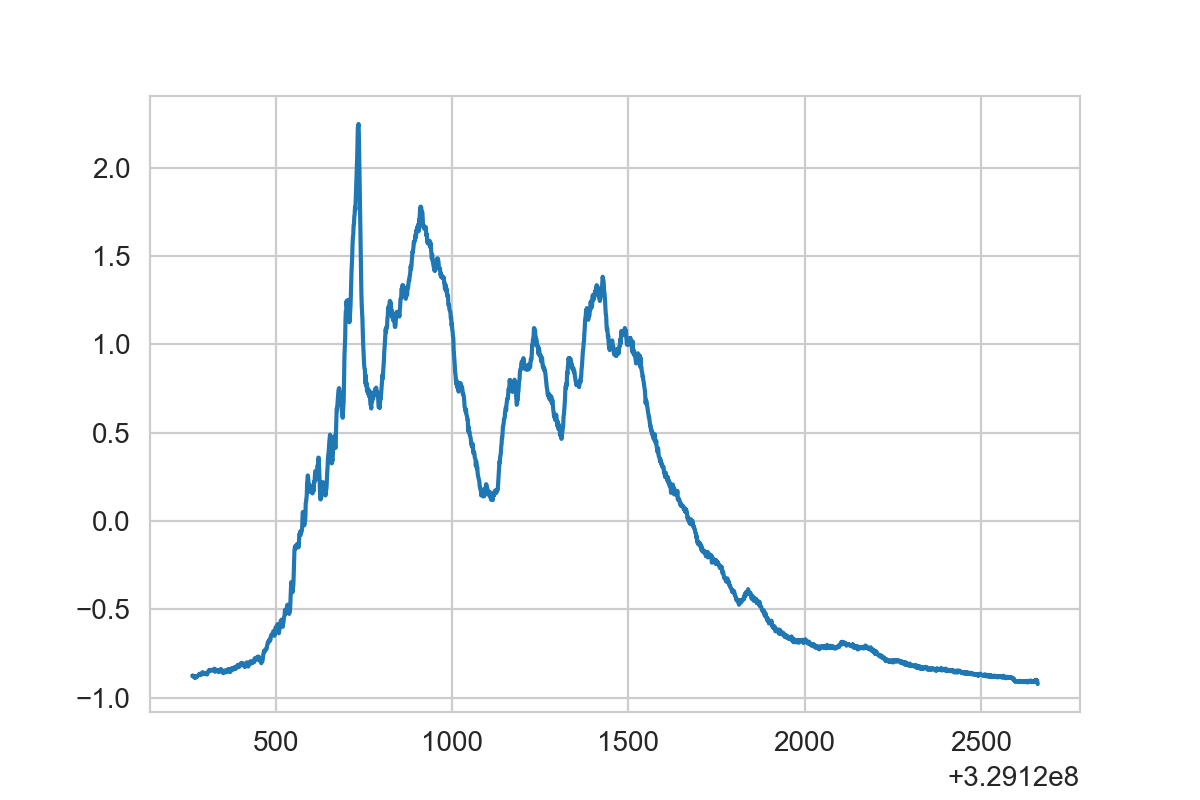

-1.0
1.4812664100227355


<IPython.core.display.Javascript object>


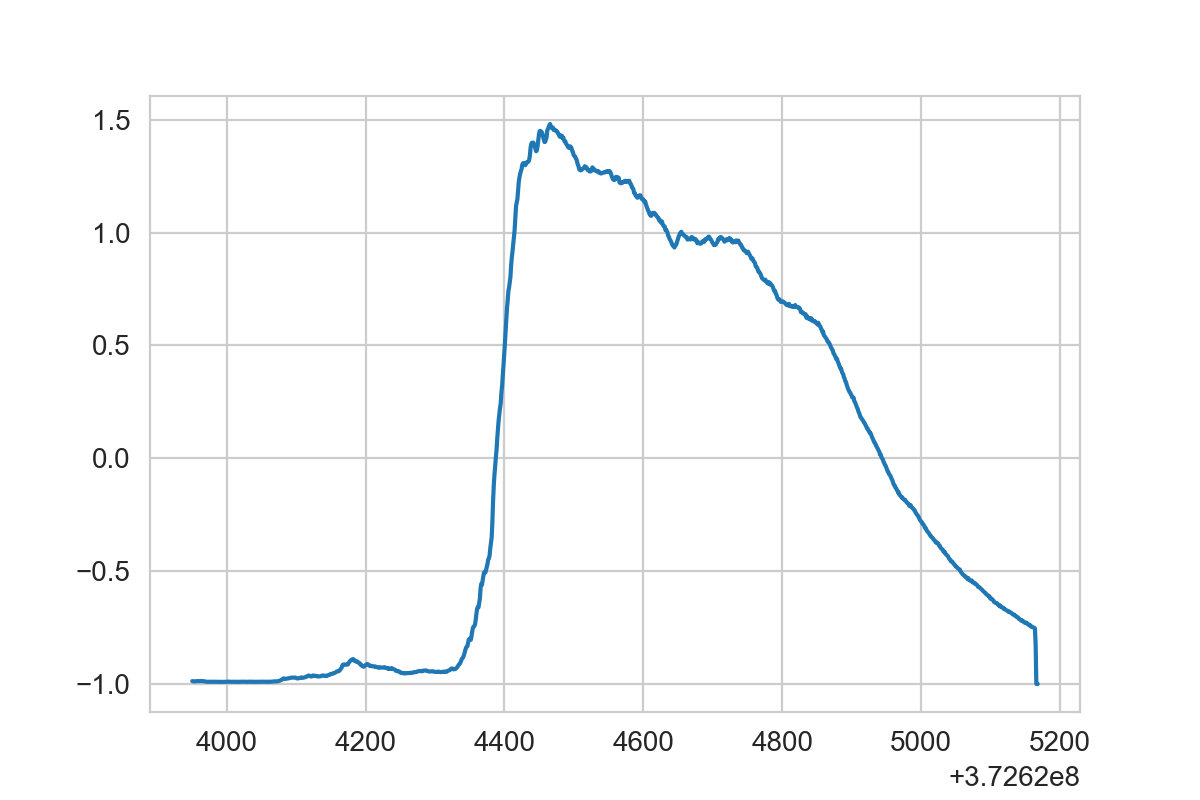

-0.6039414501390555
5.385026550150155


<IPython.core.display.Javascript object>


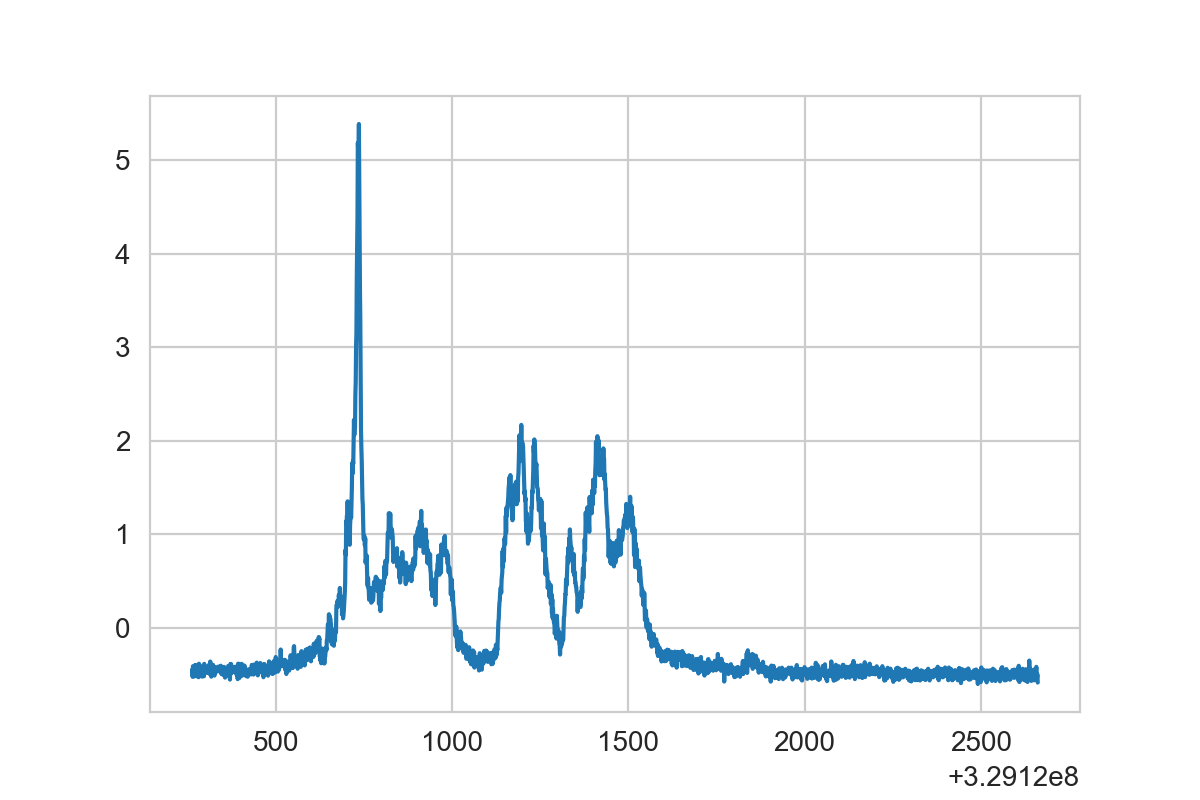

-0.9762275119434807
2.3837324978314207


<IPython.core.display.Javascript object>


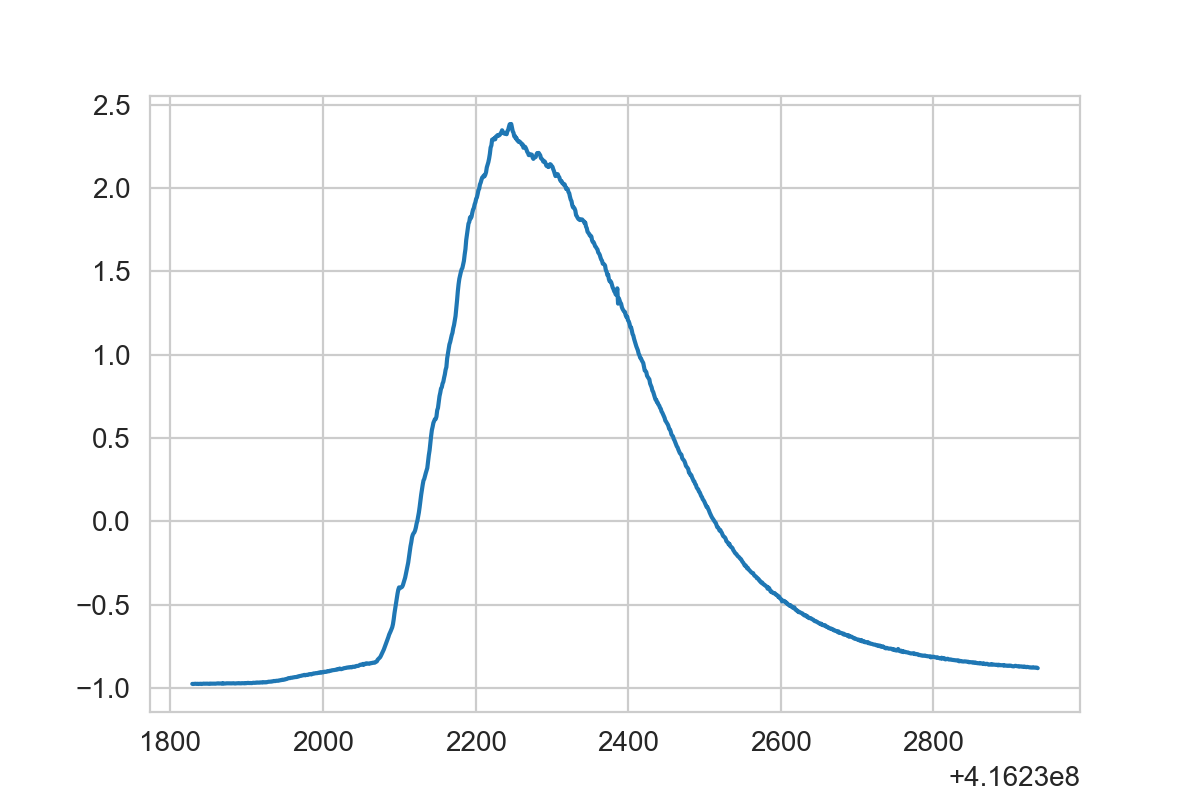

-0.9664720792172884
3.099907215891744


<IPython.core.display.Javascript object>


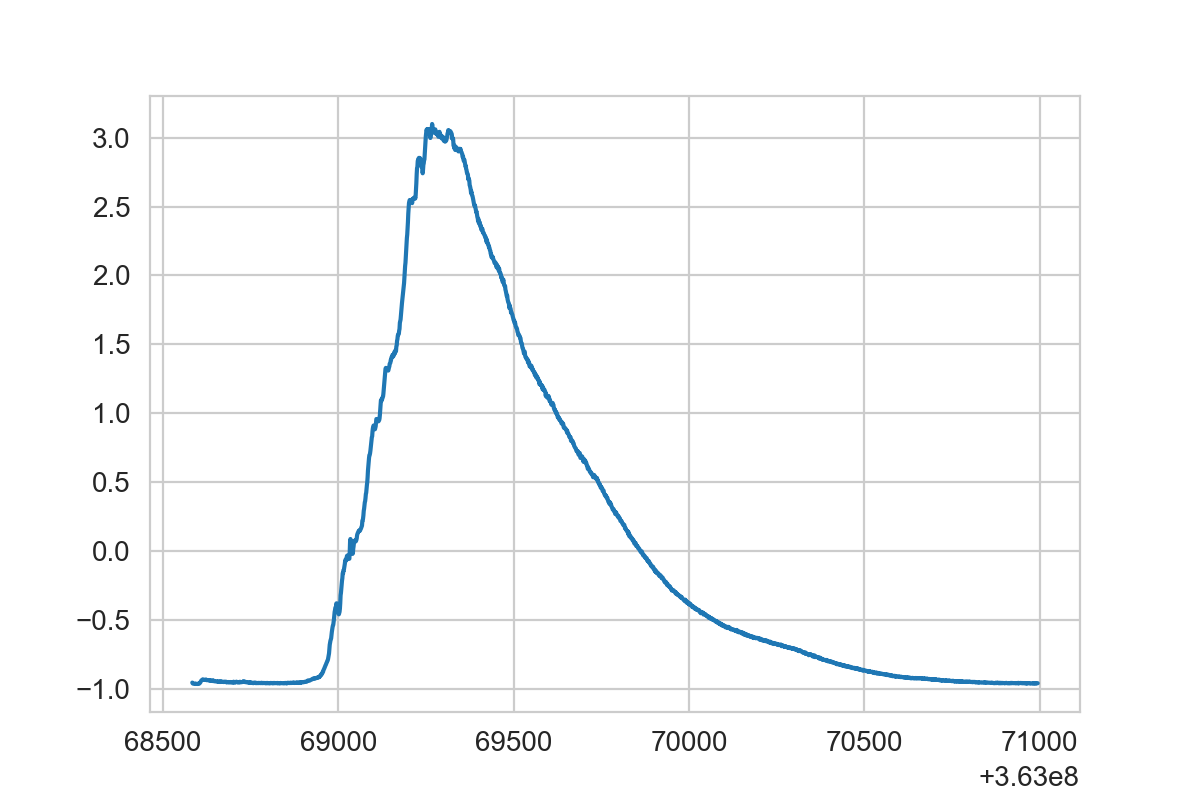

In [244]:

for f in lc_files:
    
    data = np.loadtxt(f)

    # compute the mean of the count rate
    mean_cr = np.mean(data[:,1])

    # compute the normalized count rate
    cr_norm = (data[:,1] - mean_cr)/mean_cr

    # create a Lightcurve object
    lc = Lightcurve(data[:,0], cr_norm, err=data[:,2], input_counts=False)

    # generate the window function
    #window = scipy.signal.hann(lc.n)

    # multiply counts by window
    #lc.counts *= window

    print(np.min(lc.counts))
    print(np.max(lc.counts))
    # generate the PSD
    #ps = Powerspectrum(lc, norm="abs")

    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    ax.plot(lc.time, lc.counts)

We're going to make a function to do the whole modelling in one go:

In [249]:
def model_periodogram(filename):
    # load the data from file
    # file should contain 3 columns:
    # time, countrate, countrate error
    data = np.loadtxt(filename)
    
    fsplit = f.split("/")[-1].split("_")[0]
    
    # compute the mean of the count rate
    mean_cr = np.mean(data[:,1])
    
    # compute the normalized count rate
    cr_norm = (data[:,1] - mean_cr)/mean_cr
    
    # create a Lightcurve object
    lc = Lightcurve(data[:,0], cr_norm, err=data[:,2], input_counts=False)

    # generate the window function
    window = scipy.signal.hann(lc.n)

    # multiply counts by window
    lc.counts *= window
    
    # generate the PSD
    ps = Powerspectrum(lc, norm="abs")
        
    # create the models
    # define power law component
    pl = models.PowerLaw1D()

    # fix x_0 of power law component
    pl.x_0.fixed = True

    # define constant
    c = models.Const1D()

    # make compound model
    s0 = pl + c

    @custom_model
    def LogGaussian(x, amplitude=1.0, period=0.0, stddev=1.0):
        logx = np.log(x)

        amp_total = amplitude/np.sqrt(2. * np.pi * stddev**2.)
        gauss = amp_total * np.exp(-(np.log(x) - np.log(1./period))**2./(2.*stddev**2.))

        return gauss
    
    g = LogGaussian()

    s1 = pl + g + c

    # broken power law model
    bpl = models.BrokenPowerLaw1D()

    # add constant
    s2 = bpl + c
    
    
    # define the priors for all three models
    s0_prior = {"amplitude_0": (lambda amp: (-10 < np.log(amp)) & (np.log(amp) < 10)),
                "alpha_0": (lambda alpha: (-1 < alpha) & (alpha < 6)),
                "amplitude_1": (lambda amp1: (-20 < np.log(amp1)) & (np.log(amp1) < 10))}

    s1_prior = {"amplitude_0": (lambda amp: (-10 < np.log(amp)) & (np.log(amp) < 10)),
                "alpha_0": (lambda alpha: (-1 < alpha) & (alpha < 6)),
                "amplitude_1": (lambda amp1: (-6 < np.log(amp1)) & (np.log(amp1) < 5)),
                "period_1": (lambda period: (1 < period) & (period < 300)),
                "stddev_1": (lambda stddev: (0.05 < stddev) & (stddev < 0.25)),
                "amplitude_2": (lambda amp2: (-20 < np.log(amp2)) & (np.log(amp2) < 10)),
    }

    s2_prior = {"amplitude_0": (lambda amp: (-10 < np.log(amp)) & (np.log(amp) < 10)),
                "alpha_1_0": (lambda alpha: (-1 < alpha) & (alpha < 6)),
                "alpha_2_0": (lambda alpha: (-1 < alpha) & (alpha < 6)),
                "x_break_0": (lambda fbreak: (-10 < np.log(fbreak)) & (np.log(fbreak) < 6)),
                "amplitude_1": (lambda amp1: (-20 < np.log(amp1)) & (np.log(amp1) < 10))}

    # define the Posterior objects
    ll_s0 = PSDPosterior(ps.freq, ps.power, s0, m=1, priors=s0_prior)
    ll_s1 = PSDPosterior(ps.freq, ps.power, s1, m=1, priors=s1_prior)
    ll_s2 = PSDPosterior(ps.freq, ps.power, s2, m=1, priors=s2_prior)    

    # the parameter estimation object
    parest = PSDParEst(ps, fitmethod="powell", max_post=True)
    
    # starting guesses for the parameters
    amp = ps.power[1]
    amp_qpo = amp/10.0
    
    pl_index1 = 2.0
    pl_index2 = 0.5
    whitenoise = np.mean(ps.power[-20:])
    
    s0_test = [amp, pl_index1, whitenoise]
    
    linalgerr = True
    while linalgerr == True:
        try:
            # fit the power law model
            res0 = parest.fit(ll_s0, s0_test)
            linalgerr = False
        except np.linalg.LinAlgError:
            linalgerr = True

    # calculate the residuals
    residuals = 2.*ps.power/res0.mfit
    
    # find the frequency with the maximmum power
    max_ind = np.argmax(residuals)
    
    s1_test = [amp, pl_index1, amp_qpo, 1.0/0.02, 0.1, whitenoise]
    s2_test = [amp, 0.02, pl_index2, pl_index1, whitenoise]

    linalgerr = True    
    while linalgerr == True:
        try:
            res1 = parest.fit(ll_s1, s1_test)
            linalgerr = False
        except np.linalg.LinAlgError:
            linalgerr = True

    linalgerr = True
    while linalgerr == True:
        try:
            res2 = parest.fit(ll_s2, s2_test)
            linalgerr = False
        except np.linalg.LinAlgError:
            linalgerr = True

    
    # calculate the difference in BICs:
    dbic1 = res1.bic - res0.bic
    dbic2 = res1.bic - res2.bic
    dbic3 = res2.bic - res0.bic
    print("The BIC for model S0 is: " + str(res0.bic))
    print("The BIC for model S1 is: " + str(res1.bic))
    print("The BIC for model S2 is: " + str(res2.bic) + "\n")
    
    print("Delta BIC for QPO+PL versus PL model (large positive number means PL is favoured): " + str(dbic1))
    print("Delta BIC for QPO+PL versus BPL model (large positive number means BPL is favoured): " + str(dbic2))
    print("Delta BIC for BPL versus PL model (large positive number means PL is favoured): " + str(dbic3))
    
    
    fig = plt.figure(figsize=(10, 8))
    grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)
    
    ax = plt.subplot(grid[0, :])
    ax.plot(lc.time, lc.countrate, lw=1, color="black", linestyle="steps-mid")
    ax.set_xlabel("Time in MET seconds")
    ax.set_ylabel("Count rate [counts/s]")
    ax.set_title(fsplit)
    
    ax1 = plt.subplot(grid[1, 0])
    ax1.loglog(ps.freq, ps.power, linestyle="steps-mid", color="black", label="data")
    ax1.plot(ps.freq, res0.mfit, lw=2, label="model")
    ax1.set_title("Model S0: Power law + Constant", fontdict={"size":10})
    ax1.set_xlabel("Frequency [Hz]", fontdict={"size":10})
    ax1.set_ylabel("Power in Absolute RMS Normalization", fontdict={"size":10})
    ax1.legend(prop={"size":10})
     
    ax2 = plt.subplot(grid[1, 1])
    ax2.loglog(ps.freq, ps.power, linestyle="steps-mid", color="black")
    ax2.plot(ps.freq, res1.mfit, lw=2)
    ax2.set_title("Model S1: Power law + Gaussian QPO + Constant", fontdict={"size":10})
    ax2.set_xlabel("Frequency [Hz]", fontdict={"size":10})
    
    ax3 = plt.subplot(grid[1,2])
    ax3.loglog(ps.freq, ps.power, linestyle="steps-mid", color="black")
    ax3.plot(ps.freq, res2.mfit, lw=2)
    ax3.set_title("Model S2: Broken Power Law + Constant", fontdict={"size":10})
    ax3.set_xlabel("Frequency [Hz]", fontdict={"size":10})
    
    plt.tight_layout()
    
    lc_name = filename.split("/")[-1]
    datadir = filename[:-len(lc_name)]
    lc_root = lc_name[:-7]
    
    plt.savefig(datadir + lc_root + "fits.pdf", format="pdf")
    #plt.close()
    
    return



In [ ]:
model_periodogram(f)

In [100]:
import warnings
warnings.filterwarnings("ignore")

In [112]:
lc_files

['../data/../data/130405_386876224.502950_4to30keV_lc.dat',
 '../data/../data/110607_329120381.547318_26to50keV_lc.dat',
 '../data/../data/110607_329120381.547318_11to27keV_lc.dat',
 '../data/../data/110607_329120381.547318_4to30keV_lc.dat',
 '../data/../data/121022_372624070.559808_4to30keV_lc.dat',
 '../data/../data/110607_329120381.547318_49to102keV_lc.dat',
 '../data/../data/140311_416231948.602970_4to30keV_lc.dat',
 '../data/../data/120704_363068611.569184_4to30keV_lc.dat']

I am on file ../data/../data/130405_386876224.502950_4to30keV_lc.dat
The BIC for model S0 is: -4986.879160247603
The BIC for model S1 is: -4969.461078351655
The BIC for model S2 is: -4989.248423070942

Delta BIC for QPO+PL versus PL model (large positive number means PL is favoured): 17.41808189594849
Delta BIC for QPO+PL versus BPL model (large positive number means BPL is favoured): 19.78734471928783
Delta BIC for BPL versus PL model (large positive number means PL is favoured): -2.3692628233393407


<IPython.core.display.Javascript object>


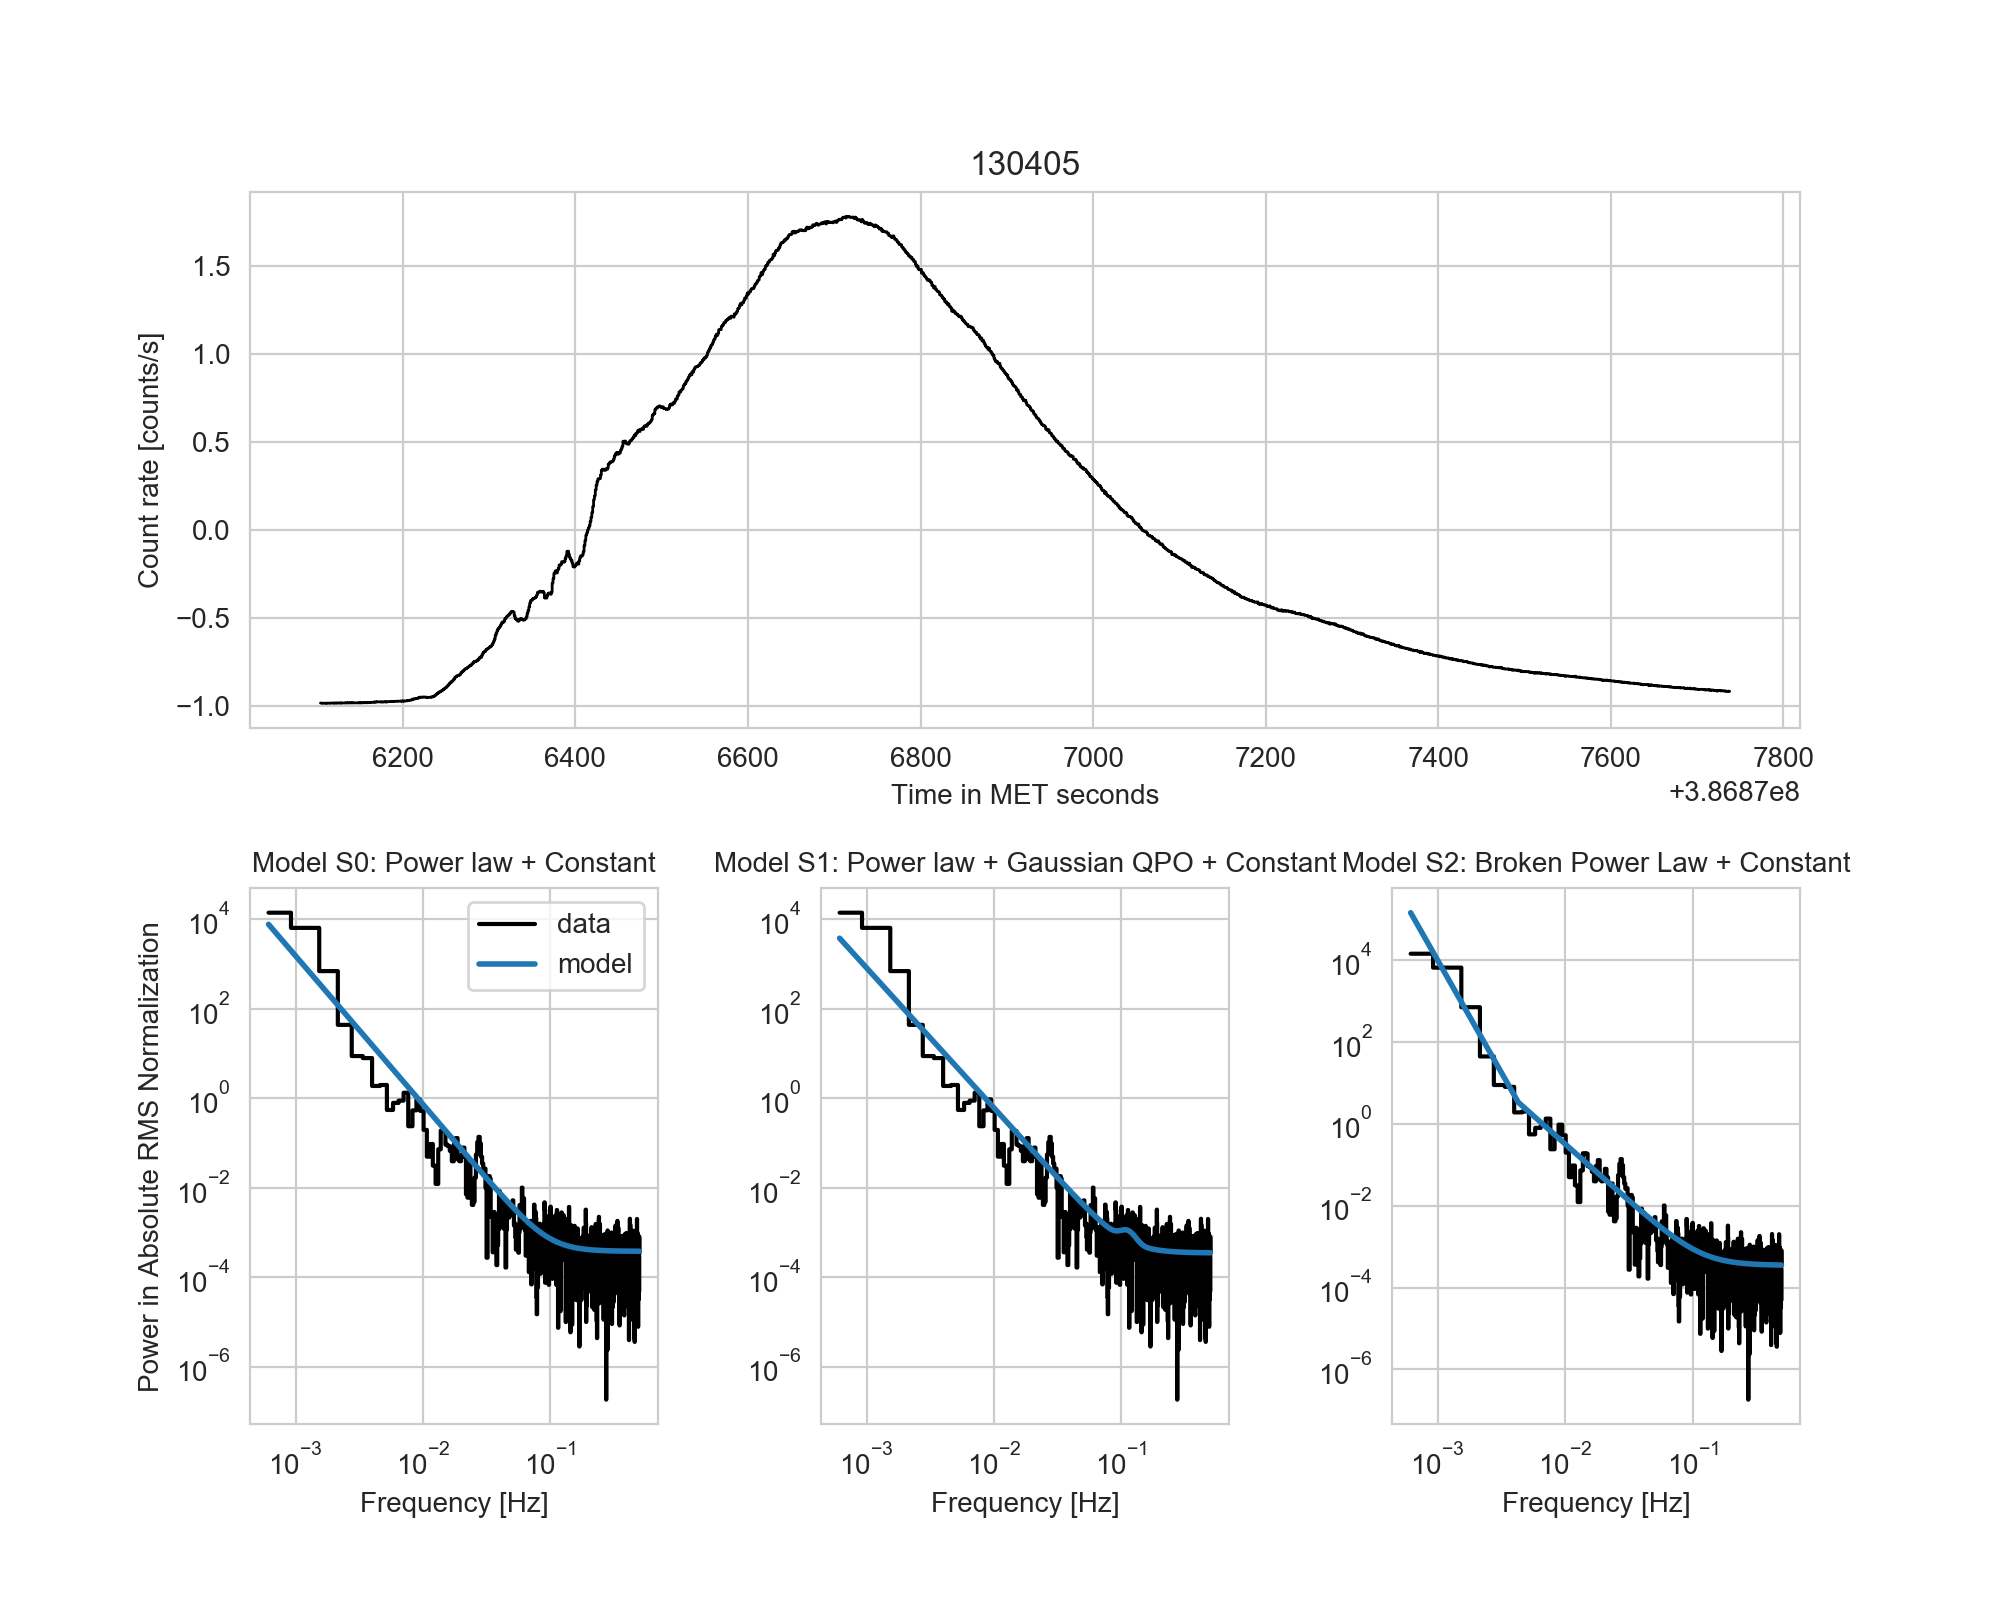

I am on file ../data/../data/110607_329120381.547318_26to50keV_lc.dat
The BIC for model S0 is: -1102.1794470767425
The BIC for model S1 is: -1084.9329123023645
The BIC for model S2 is: -1116.7551338515254

Delta BIC for QPO+PL versus PL model (large positive number means PL is favoured): 17.246534774378006
Delta BIC for QPO+PL versus BPL model (large positive number means BPL is favoured): 31.822221549160986
Delta BIC for BPL versus PL model (large positive number means PL is favoured): -14.57568677478298


<IPython.core.display.Javascript object>


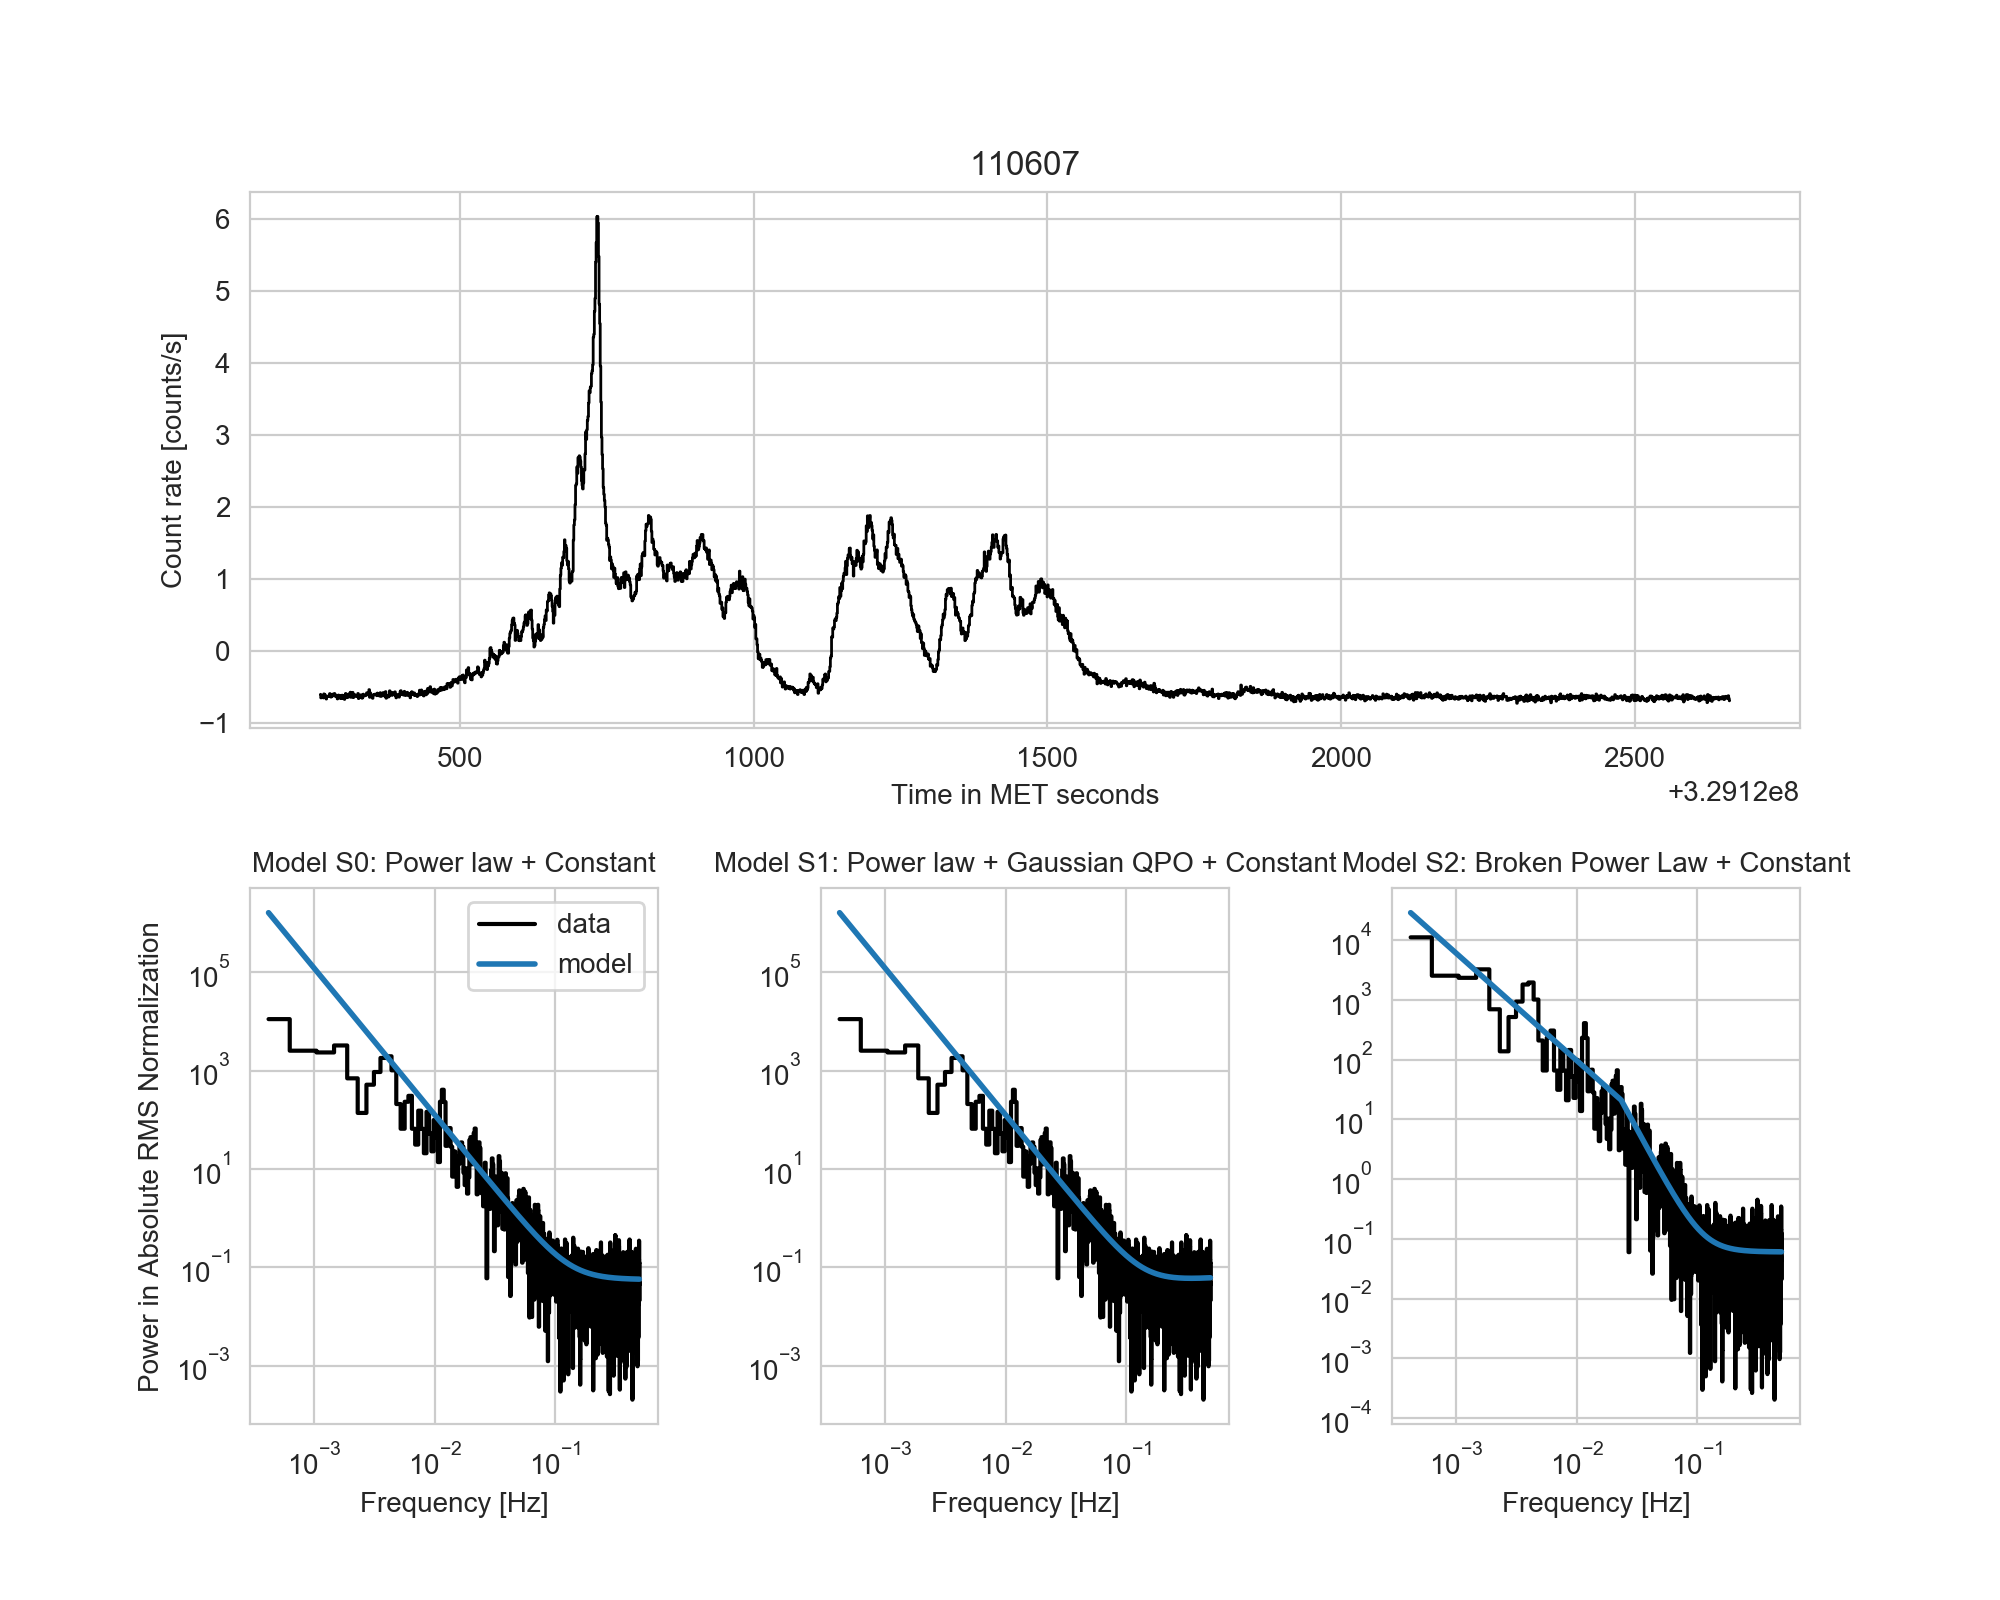

I am on file ../data/../data/110607_329120381.547318_11to27keV_lc.dat
The BIC for model S0 is: -3237.48643768295
The BIC for model S1 is: -3246.341258408696
The BIC for model S2 is: -3261.221573307125

Delta BIC for QPO+PL versus PL model (large positive number means PL is favoured): -8.854820725745867
Delta BIC for QPO+PL versus BPL model (large positive number means BPL is favoured): 14.880314898428878
Delta BIC for BPL versus PL model (large positive number means PL is favoured): -23.735135624174745


<IPython.core.display.Javascript object>


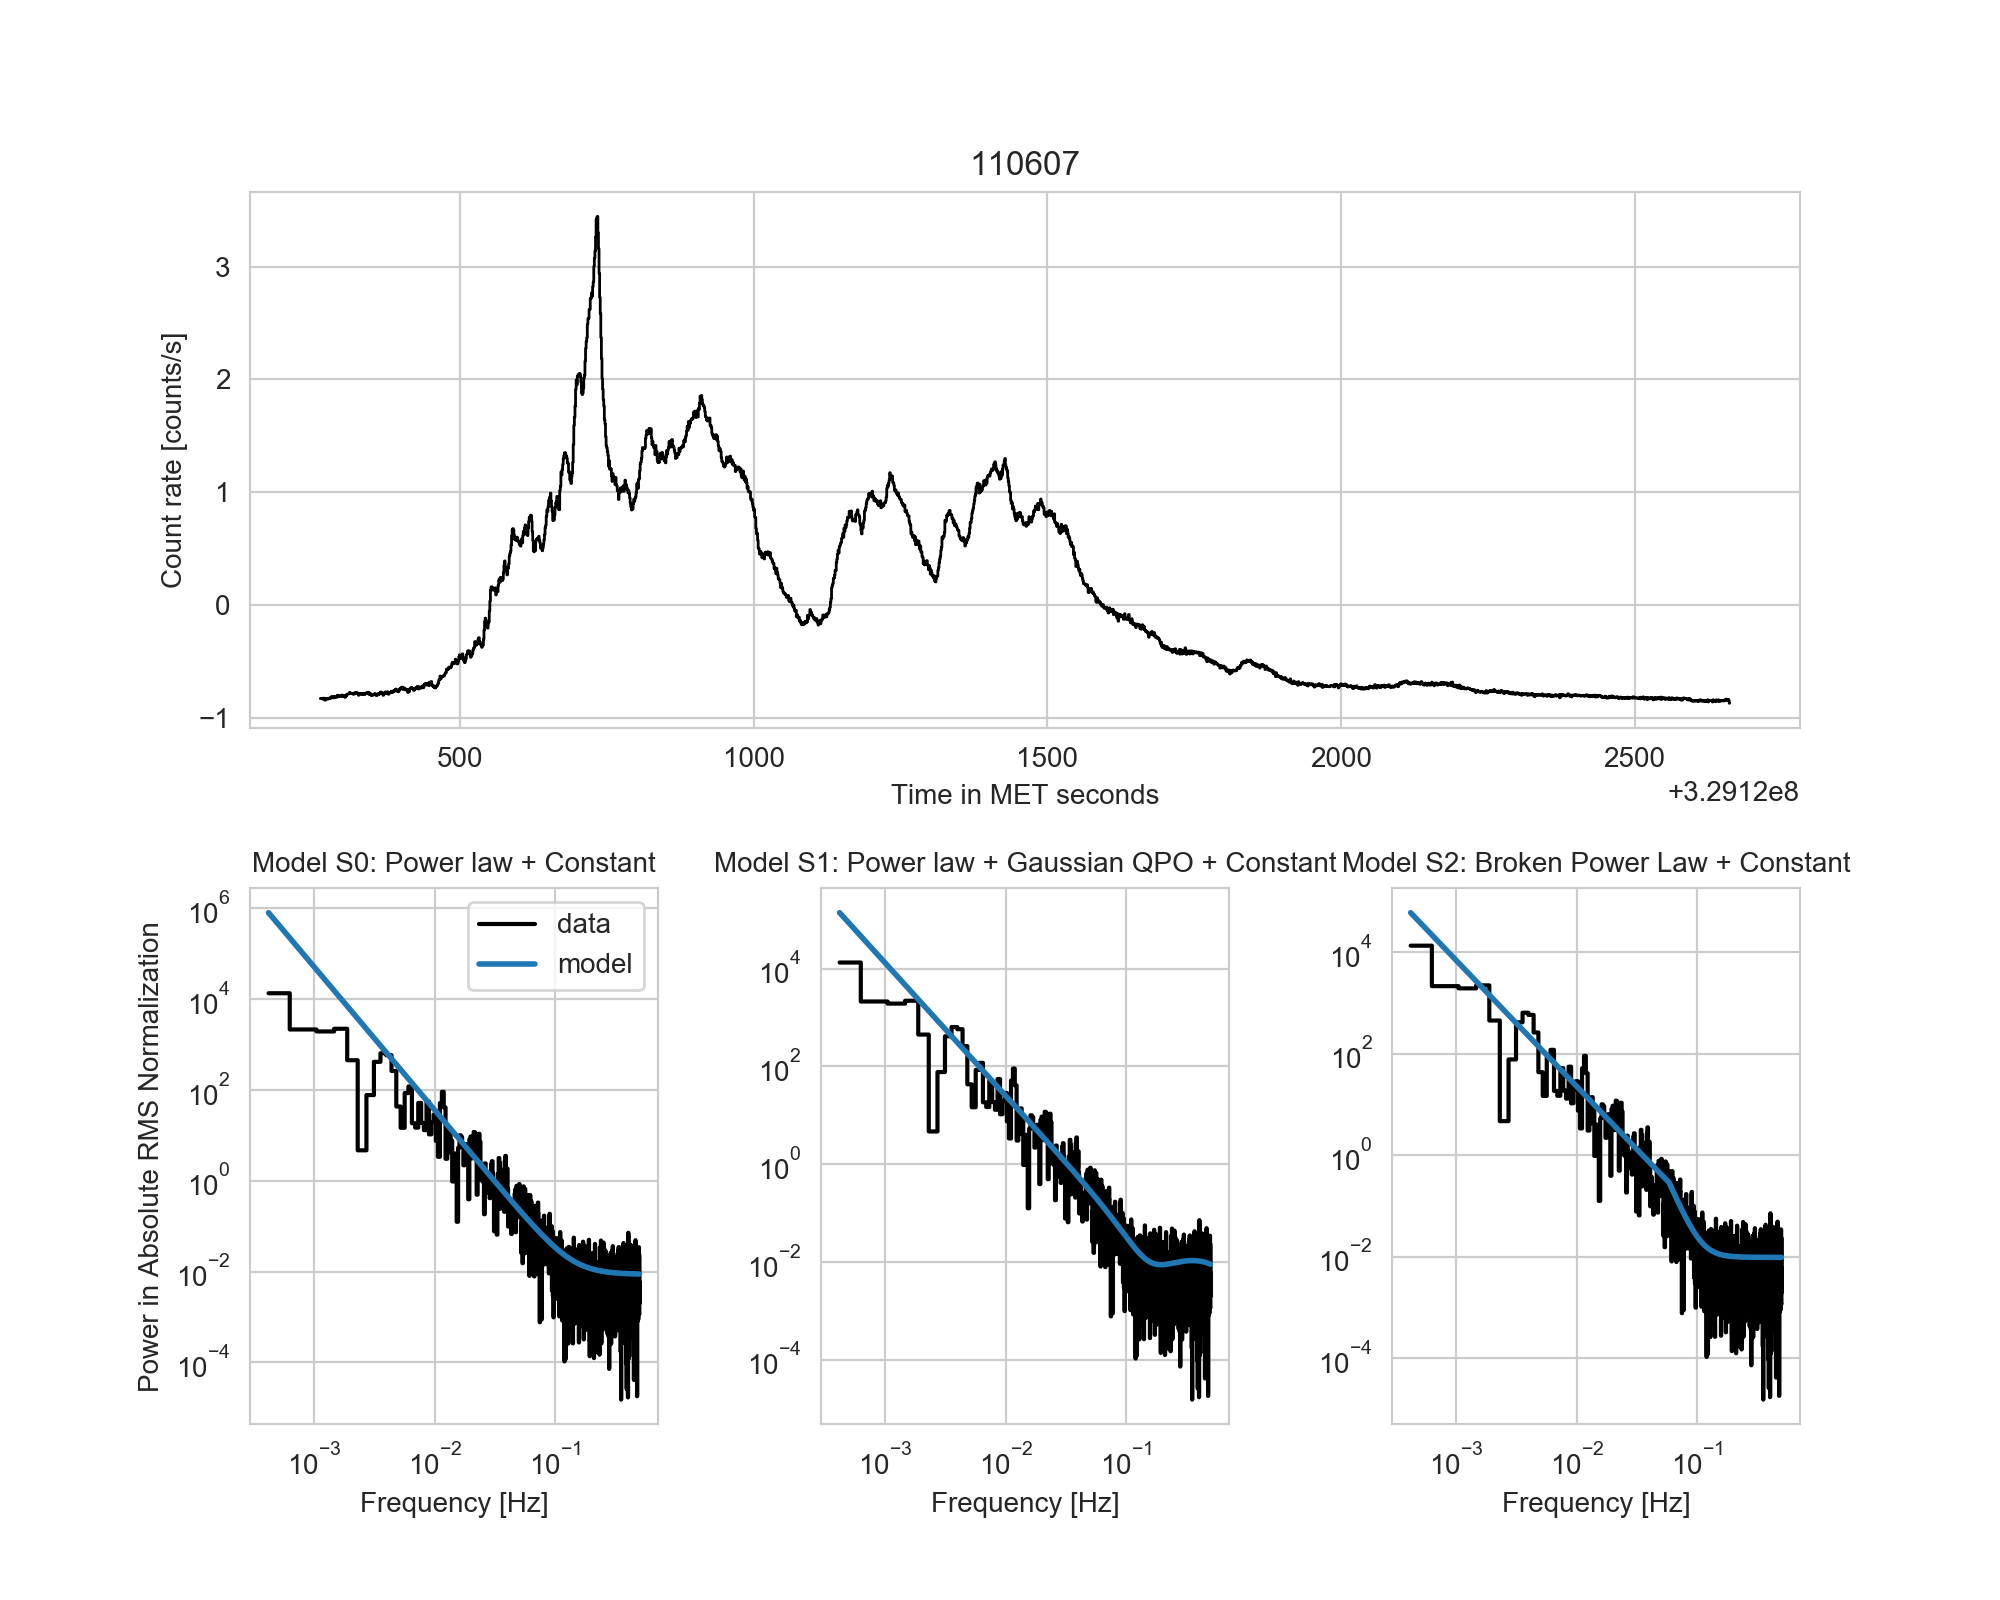

I am on file ../data/../data/110607_329120381.547318_4to30keV_lc.dat
The BIC for model S0 is: -4184.810152668998
The BIC for model S1 is: -4168.858279070883
The BIC for model S2 is: -4203.198756452445

Delta BIC for QPO+PL versus PL model (large positive number means PL is favoured): 15.951873598114616
Delta BIC for QPO+PL versus BPL model (large positive number means BPL is favoured): 34.34047738156187
Delta BIC for BPL versus PL model (large positive number means PL is favoured): -18.38860378344725


<IPython.core.display.Javascript object>


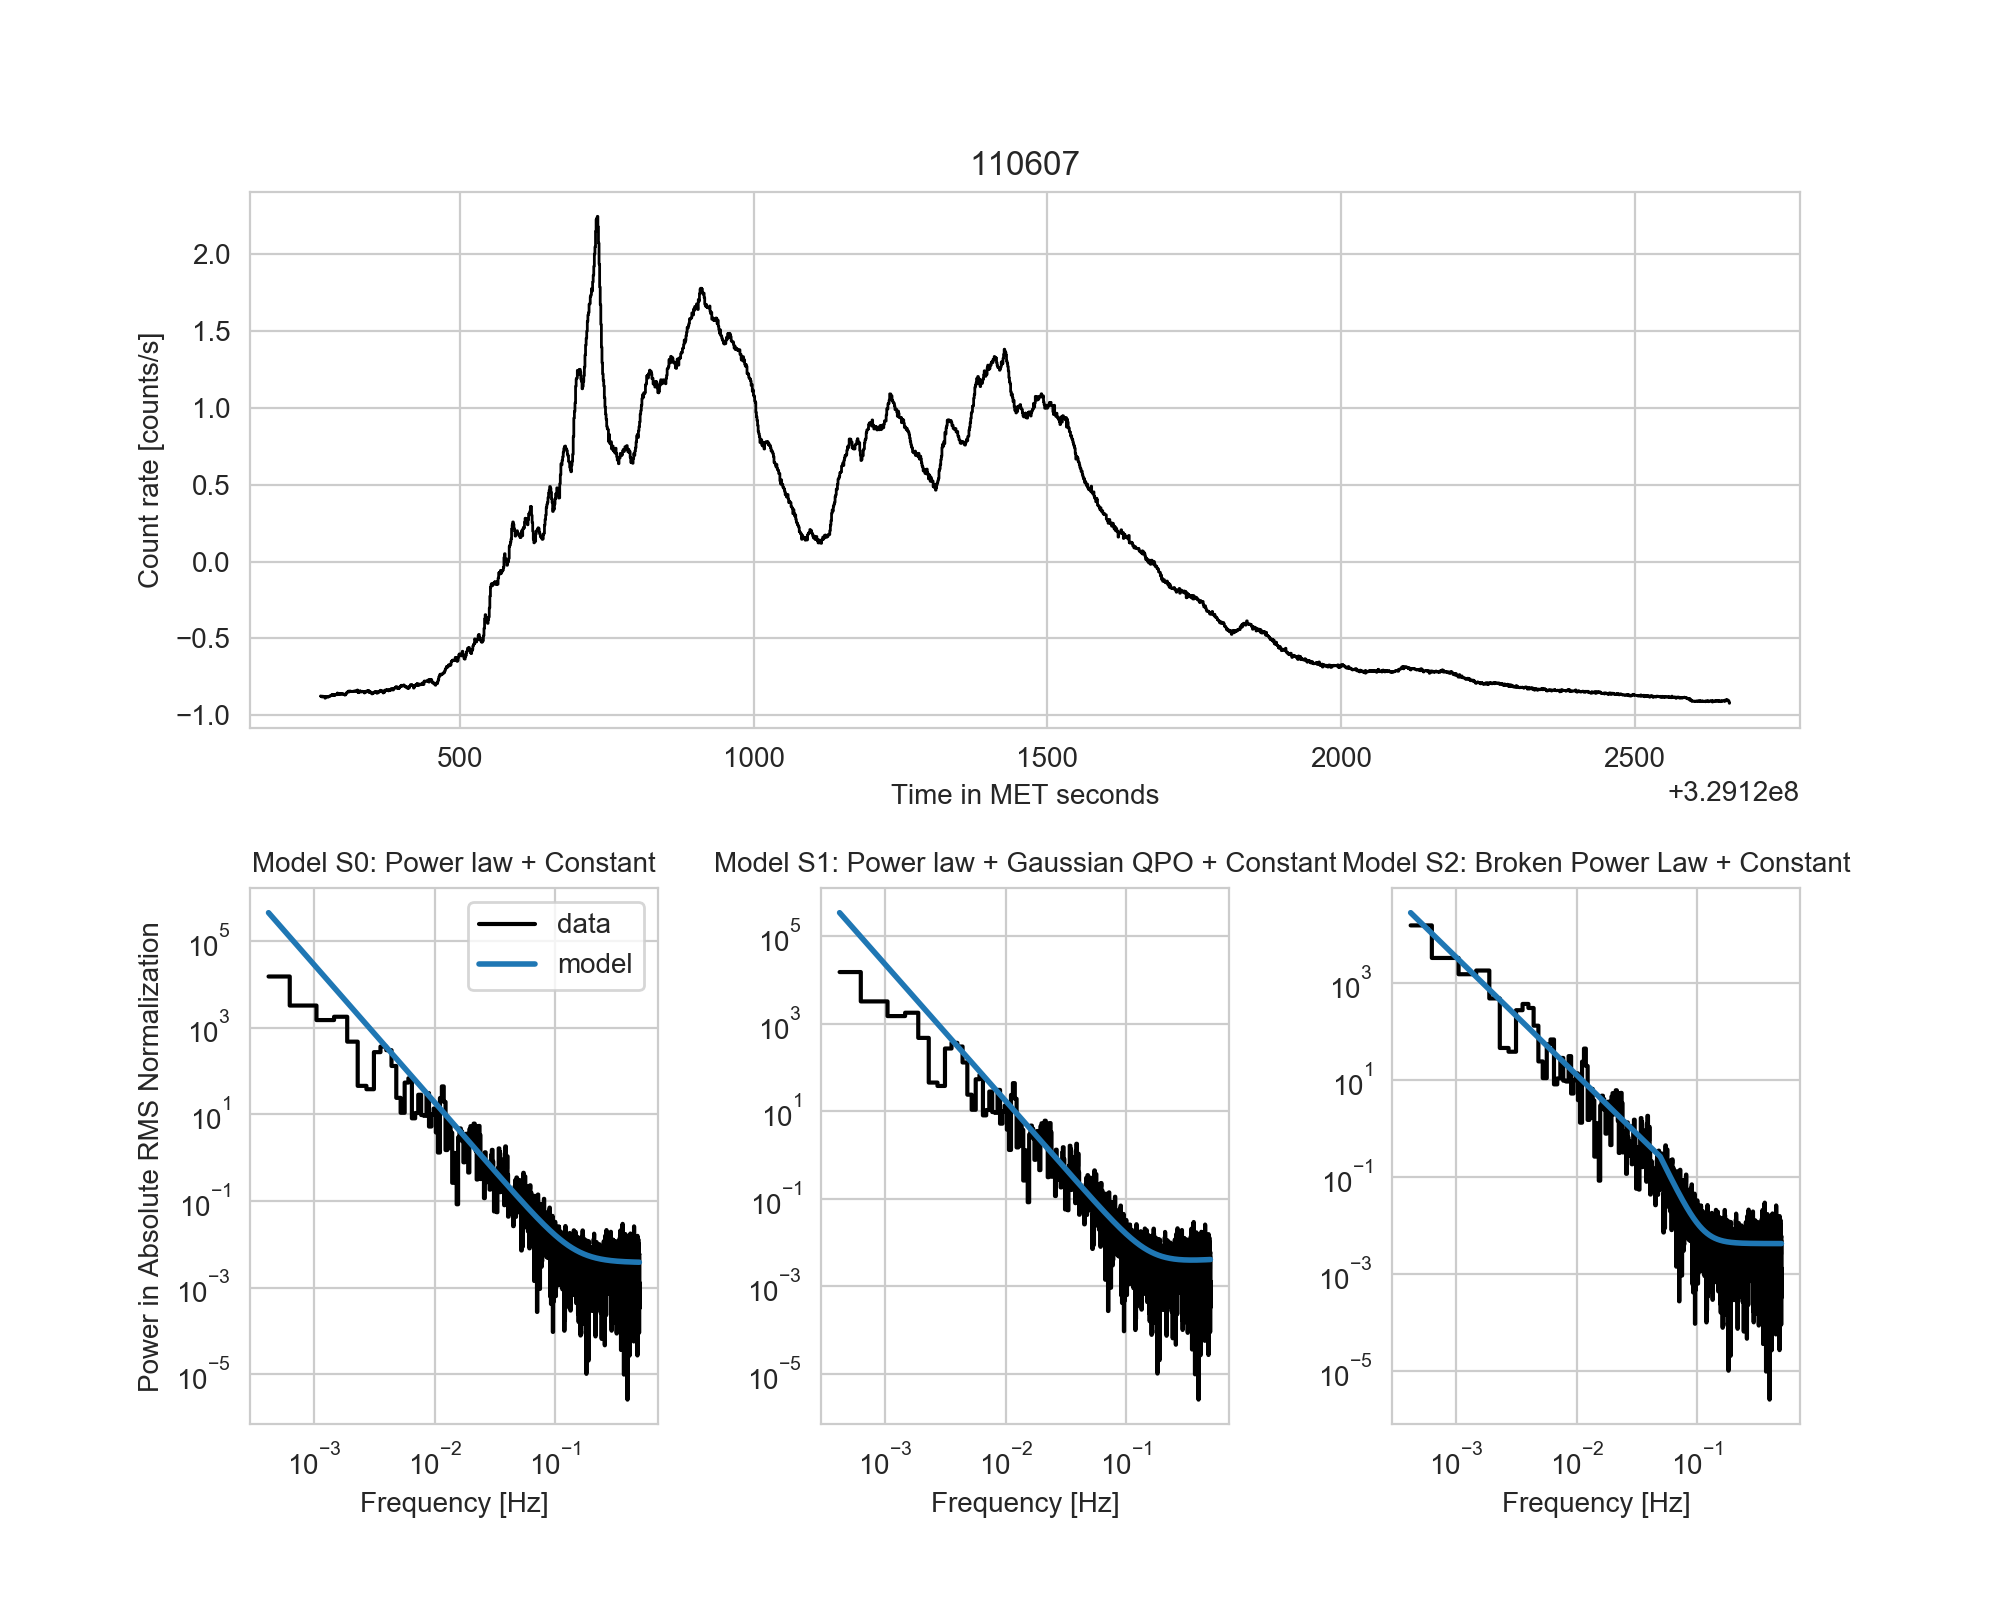

I am on file ../data/../data/121022_372624070.559808_4to30keV_lc.dat
The BIC for model S0 is: -3382.9501654714327
The BIC for model S1 is: -3363.719746984564
The BIC for model S2 is: -3374.777536121577

Delta BIC for QPO+PL versus PL model (large positive number means PL is favoured): 19.23041848686853
Delta BIC for QPO+PL versus BPL model (large positive number means BPL is favoured): 11.05778913701306
Delta BIC for BPL versus PL model (large positive number means PL is favoured): 8.17262934985547


<IPython.core.display.Javascript object>


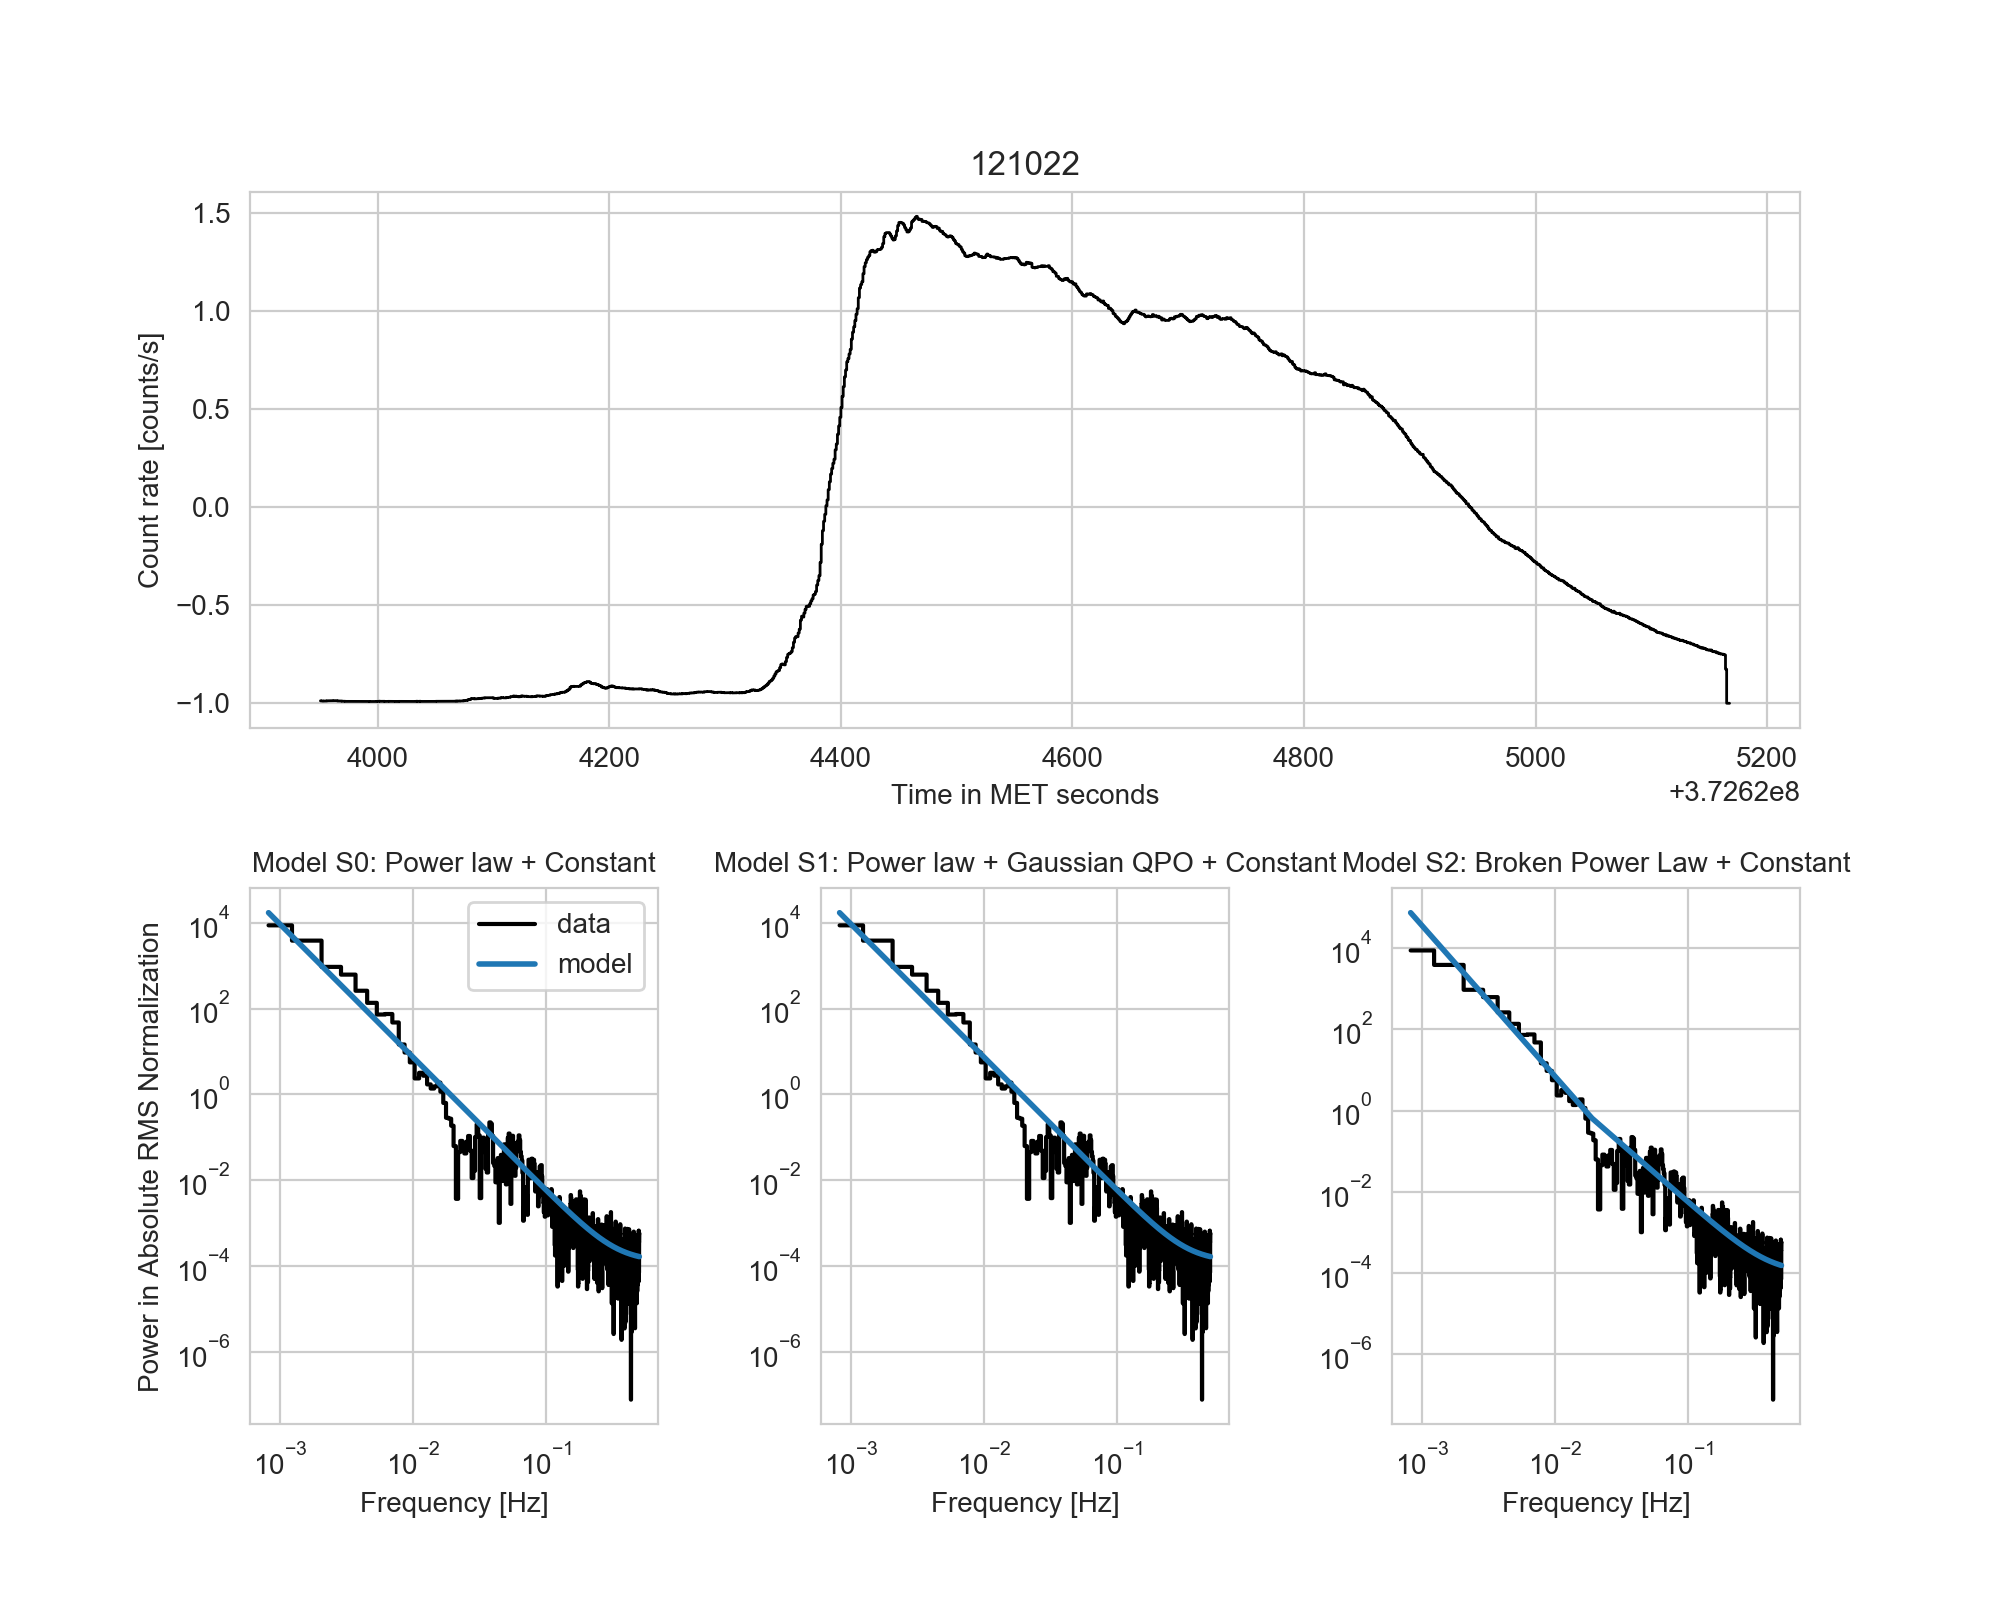

I am on file ../data/../data/110607_329120381.547318_49to102keV_lc.dat
The BIC for model S0 is: -303.1118545003528
The BIC for model S1 is: -288.71135904711355
The BIC for model S2 is: -319.0973341638552

Delta BIC for QPO+PL versus PL model (large positive number means PL is favoured): 14.400495453239273
Delta BIC for QPO+PL versus BPL model (large positive number means BPL is favoured): 30.385975116741633
Delta BIC for BPL versus PL model (large positive number means PL is favoured): -15.98547966350236


<IPython.core.display.Javascript object>


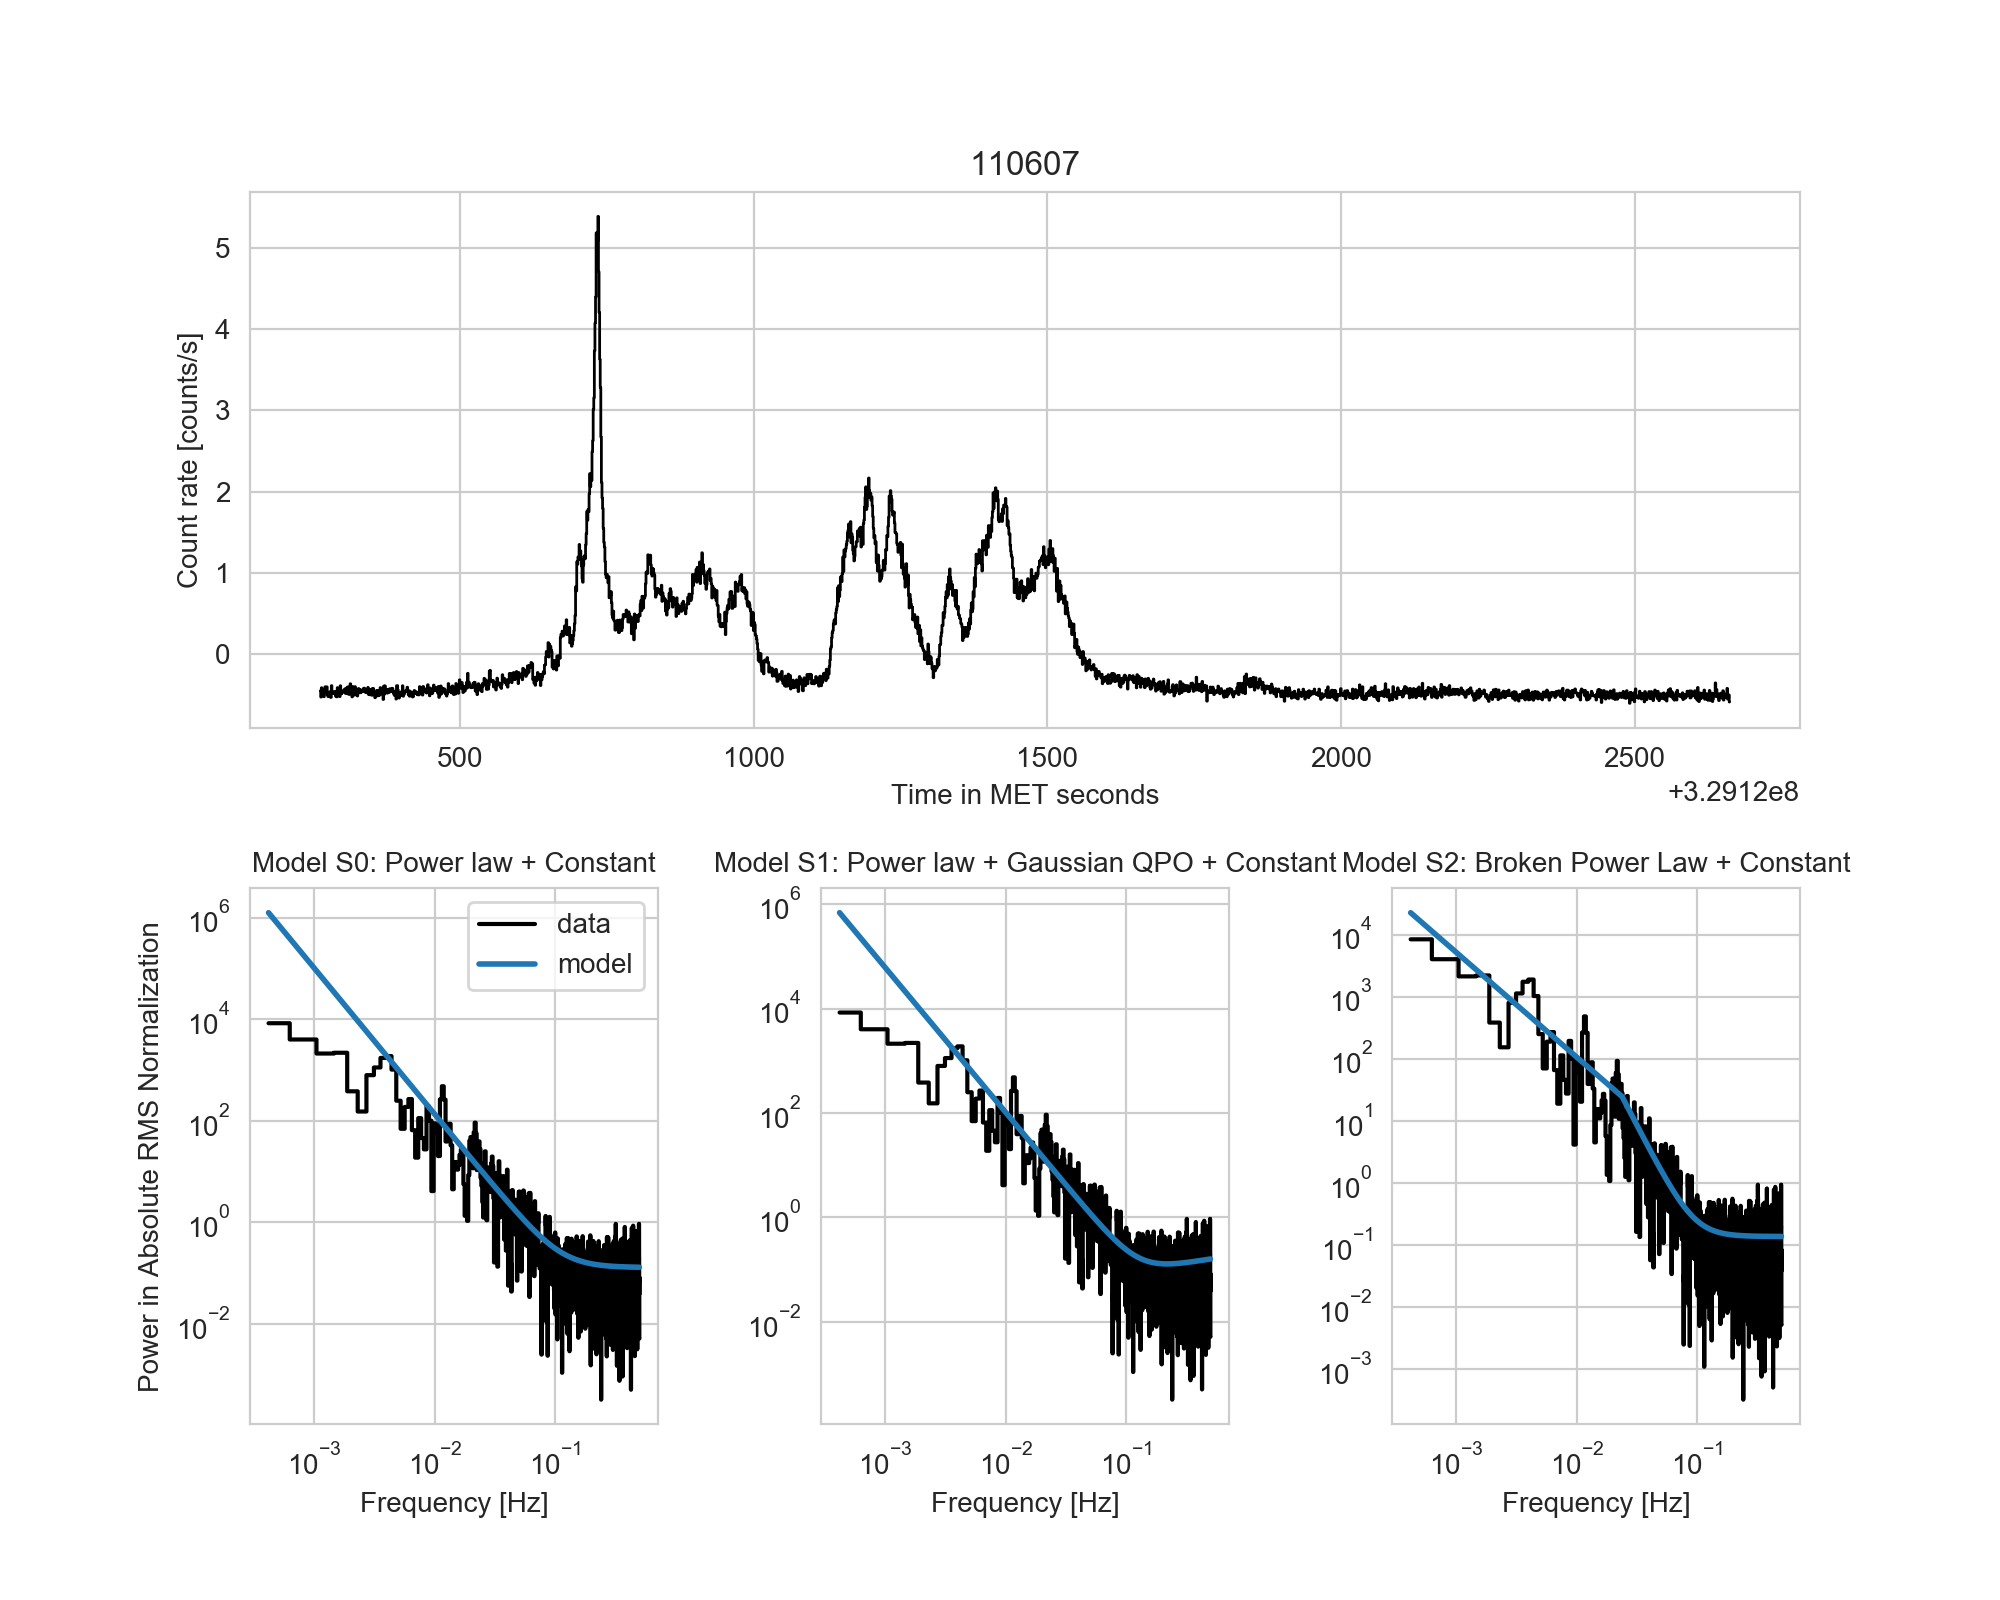

I am on file ../data/../data/140311_416231948.602970_4to30keV_lc.dat
The BIC for model S0 is: -2827.922508626869
The BIC for model S1 is: -2823.3727014338447
The BIC for model S2 is: -2828.8413644563475

Delta BIC for QPO+PL versus PL model (large positive number means PL is favoured): 4.549807193024208
Delta BIC for QPO+PL versus BPL model (large positive number means BPL is favoured): 5.468663022502824
Delta BIC for BPL versus PL model (large positive number means PL is favoured): -0.9188558294786162


<IPython.core.display.Javascript object>


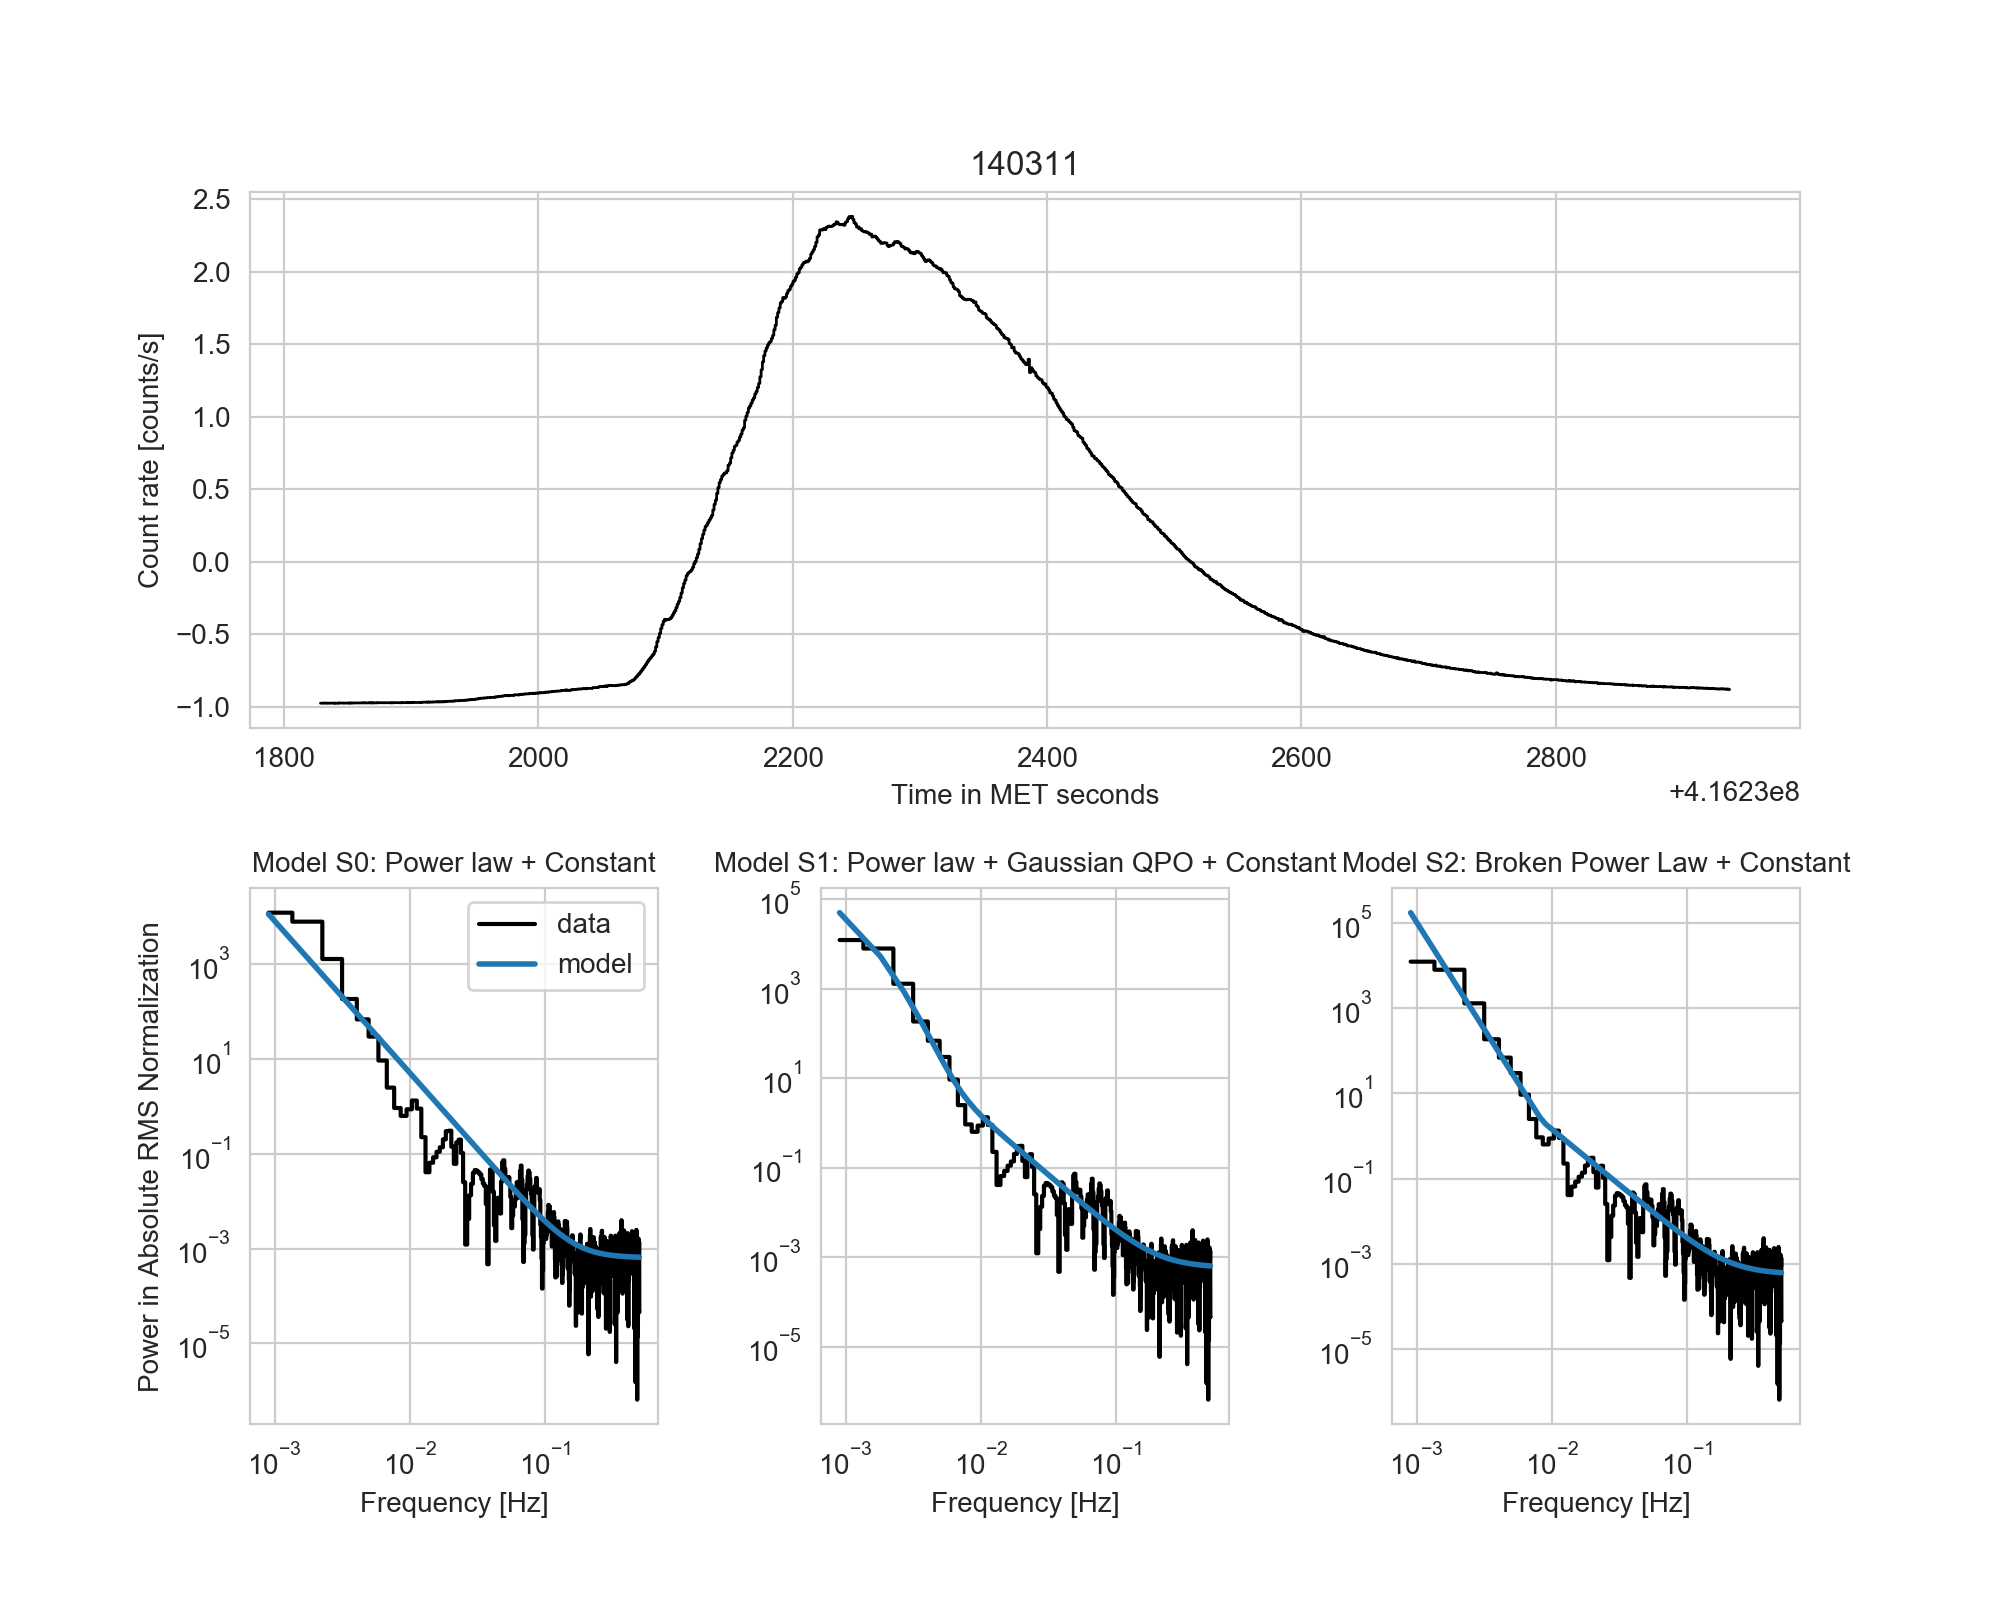

I am on file ../data/../data/120704_363068611.569184_4to30keV_lc.dat
The BIC for model S0 is: -5950.388630638943
The BIC for model S1 is: -5931.4295250318955
The BIC for model S2 is: -5942.13779020158

Delta BIC for QPO+PL versus PL model (large positive number means PL is favoured): 18.959105607047604
Delta BIC for QPO+PL versus BPL model (large positive number means BPL is favoured): 10.708265169684637
Delta BIC for BPL versus PL model (large positive number means PL is favoured): 8.250840437362967


<IPython.core.display.Javascript object>


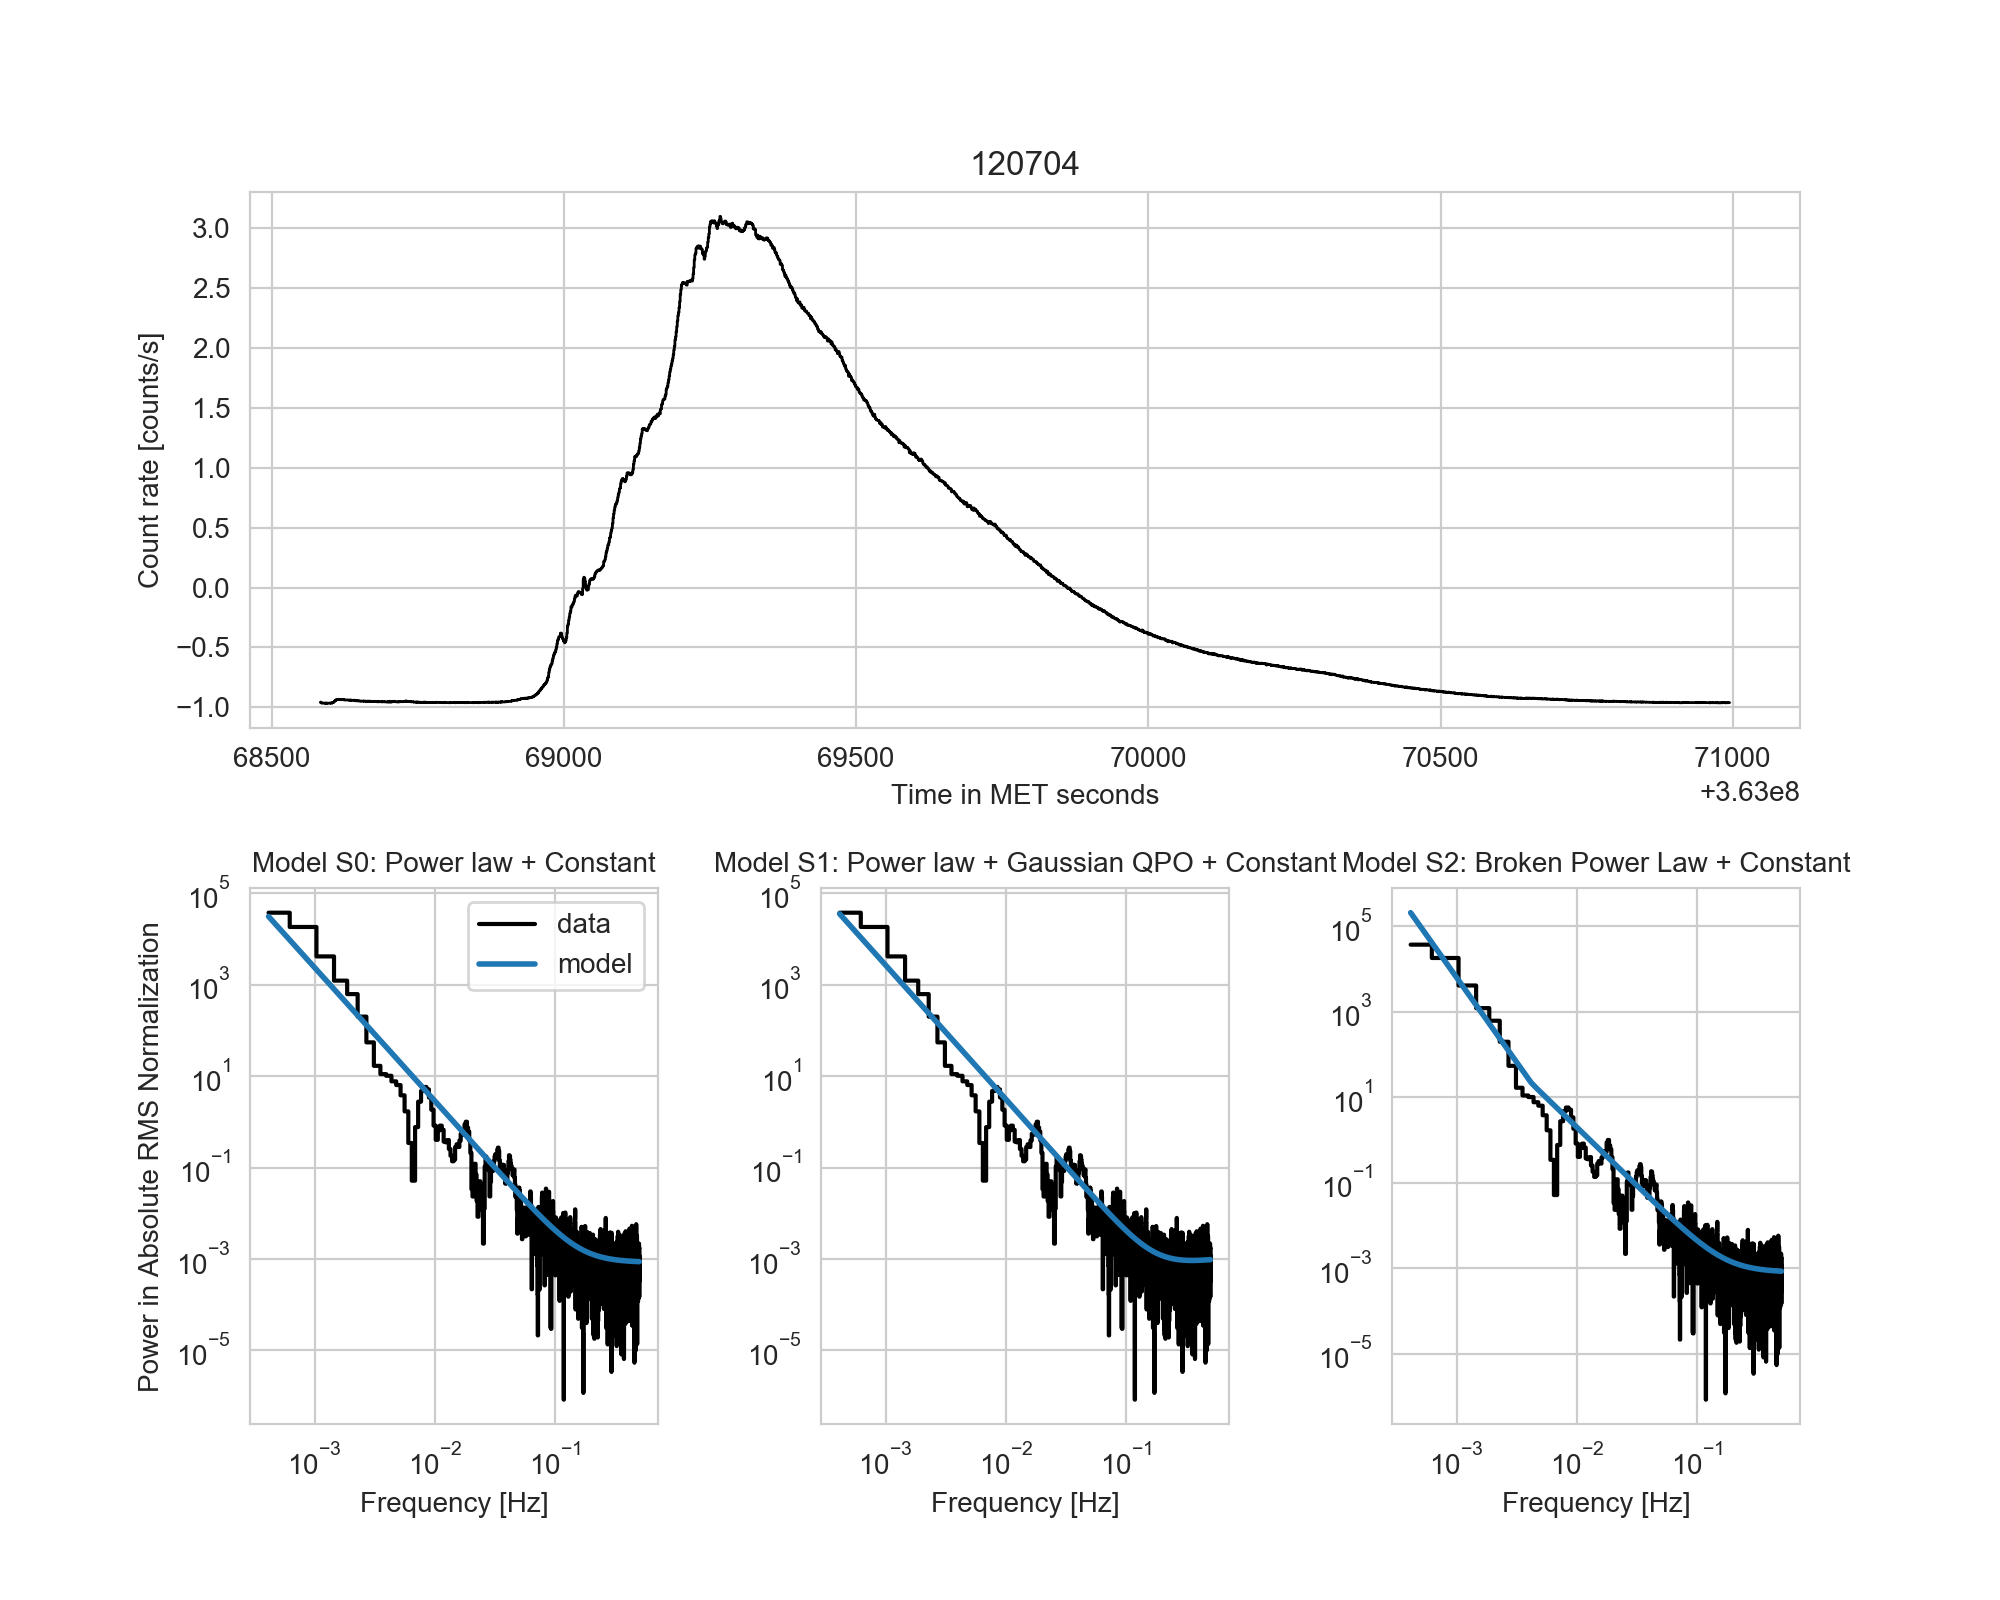

In [113]:
for f in lc_files:
    print("I am on file %s"%f)
    model_periodogram(f)